# Import Libraries

In [1]:
import mlflow
import subprocess

In [2]:
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

In [3]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [4]:
all_experiments = client.search_experiments()
print(all_experiments)

[<Experiment: artifact_location='file:///C:/Users/rajneesh.jha/Downloads/MLOPS Assignmnet 2/mlruns/1', creation_time=1725772388140, experiment_id='1', last_update_time=1725772388140, lifecycle_stage='active', name='Predicting_Credit_Card_Eligibility', tags={'mlflow.note.content': 'This experiment is used for predicting Credit Card '
                        'EligibilityThis experiment involves three different '
                        'model runs',
 'project_category': 'Classification',
 'project_name': 'Predicting Credit Card Eligibility',
 'project_quarter': 'Q3-2024',
 'team': 'credit-ml'}>, <Experiment: artifact_location='file:///C:/Users/rajneesh.jha/Downloads/MLOPS Assignmnet 2/mlruns/0', creation_time=1725772377934, experiment_id='0', last_update_time=1725772377934, lifecycle_stage='active', name='Default', tags={}>]


In [5]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This experiment is used for predicting Credit Card Eligibility"
    "This experiment involves three different model runs"
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Predicting Credit Card Eligibility",
    "project_category": "Classification",
    "team": "credit-ml",
    "project_quarter": "Q3-2024",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="Predicting_Credit_Card_Eligibility", tags=experiment_tags
)

In [6]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [7]:
mlflow.set_experiment("Predicting_Credit_Card_Eligibility")

<Experiment: artifact_location='file:///C:/Users/rajneesh.jha/Downloads/MLOPS Assignmnet 2/mlruns/1', creation_time=1725772388140, experiment_id='1', last_update_time=1725772388140, lifecycle_stage='active', name='Predicting_Credit_Card_Eligibility', tags={'mlflow.note.content': 'This experiment is used for predicting Credit Card '
                        'EligibilityThis experiment involves three different '
                        'model runs',
 'project_category': 'Classification',
 'project_name': 'Predicting Credit Card Eligibility',
 'project_quarter': 'Q3-2024',
 'team': 'credit-ml'}>

In [8]:
run_name = "Credit Eligibility"
# Define an artifact path that the model will be saved to.
artifact_path = "MLRun_CreditEligibility"

In [13]:
%matplotlib inline

In [9]:
import dtale
import functools
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import re
import seaborn as sns
import usaddress
import xgboost as xgb

from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import auc, recall_score,precision_score,confusion_matrix,f1_score,average_precision_score,roc_auc_score,roc_curve,brier_score_loss
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [14]:
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [15]:
credit_data=pd.read_csv("credit_data.csv")
print(credit_data.shape)

(45222, 21)


## Summary Of Columns

In [16]:
def columns_summary(input_df):
    summary_dict={}
    for col in input_df.columns:
        summary_dict[col]={}
        summary_dict[col]["# Unique Values"]=input_df[col].nunique()
        summary_dict[col]["5 Point Summary "]=dict(input_df[col].describe())
        summary_dict[col]['Percentage of Nulls']=str(input_df[col].isnull().sum()/len(input_df[col])*100)+str("%")
        summary_dict[col]["Top Values"]=input_df[col].value_counts().index.tolist()

    return pd.DataFrame(summary_dict).T

In [17]:
summary_df=columns_summary(credit_data)
display(summary_df)

,# Unique Values,5 Point Summary,Percentage of Nulls,Top Values
user_id,45222,"{'count': 45222, 'unique': 45222, 'top': '307c73a3-0c67-43b5-b0d1-62ad5f00b52a', 'freq': 1}",0.0%,"[307c73a3-0c67-43b5-b0d1-62ad5f00b52a, fa16841c-d447-4ace-9fe7-d2da3d9c8600, ff52bd6a-153d-446f-b361-3349e78cb768, 20ccd9bb-62c0-4786-a448-3feb8a8f179d, 46ec8435-e84c-4739-b723-c2168c9c78a7, 4d933c73-ac17-419e-9a8b-7a54030e6142, d8a639eb-4921-4fc5-a7f5-45d89d84cbd6, d545c9e2-8d28-497e-95fd-f8b8f5ae8a55, 3640219e-46b8-4d89-9ffa-aaf95f0ed8e3, 3c1a1238-a5de-48f4-8d89-6bf0122a2b52, e824e04a-0135-4f5f-9f18-ea1511257c32, fb4a2b69-6d82-43ce-bbca-aa6482a75391, 66711fbe-d4cf-4621-b83f-388d24e34d9c, a271273f-509d-400d-86b0-a5d20e67576c, c324f685-7442-4205-a1da-f3411a2ac4ca, 4b8a9066-0030-466e-996f-496eeff97a32, 759aa354-db38-4bd6-934a-666e84e2105b, 9d66c801-9479-4ea9-80b7-beff4bf53add, 58688d89-864b-4799-b1c0-b6aeaf22d9b2, 115313e5-9c58-40d8-95b8-53b6804e4893, bf465d09-8994-44fc-b8e9-c953051def37, 9f259f8b-f42c-46ab-9d83-ad339bcfea93, d3966eef-bed5-45d3-8cff-7ead31ffc5fd, 21ac4744-1489-498d-be71-ec6cb6cbb8d3, 0c2dd8e1-8a0b-4eb2-b7cf-0971d0de9a61, 5987a562-7117-4cae-a121-4a9ac3a44587, 7963b248-519e-4946-a1bd-ed10bcb01c94, 106473ec-b357-473b-949d-f81294847a0e, a7134c37-6c56-4408-87e8-e4fa90c0ca49, 31f369af-1b00-422b-bae0-33fe65f64c17, 9c717742-d359-4142-8790-6f0931c67967, be348630-9ccc-4665-a910-8247d24ca258, 104716e5-e796-49b5-80c5-0d1b7c5823e5, 0037ff7b-1095-445c-8616-b6ae9f43eb31, 67ce69d2-192f-465c-9d48-5e66eb239482, f14bebfa-33e4-4339-93cd-a626669365f0, 667f1c7d-b077-4a76-a026-ebccb72faf45, 615d491d-9f91-4afd-8812-af41ae4bc172, 1b4f9105-1e23-4595-8222-a775c9a1989f, 8dd728cb-9a93-4ec7-a7d5-48064cf443b4, 23a14a31-335a-48a9-ab62-dd0fc970869e, 36e4648a-f552-46b3-bfb2-23061d25c596, 1769e0f6-b3c5-4df5-83c7-744e1d8f2aa2, d6fd39df-aacc-40f9-b062-559727efc925, d5b3cf4a-e4b2-4bac-95c5-ed3f040574c3, 1baf737b-0da6-4f20-b85b-f510c42157cf, 7e5407dd-a4b5-4dd9-ae82-2e30fb2458e2, 32e6b285-4c24-4006-a1e4-916c1faa6d57, 4c01c945-269e-44e0-b2c4-9d56710eab6b, 4f01871e-35b3-41bd-8b7d-2eb86d28a28b, 50a8644c-0580-44a0-812b-8712a53354b6, c6269357-2f7c-4f38-951d-a20eccb7fc09, 4090eb65-e95d-4eba-80a2-588543839a83, 75a58ce5-82f9-4618-9496-ce0acd6e0a35, 950cec8c-bfc8-4082-a9ca-07ddc8328586, ce0c1a16-448a-4058-ae45-13920e976bee, 7c13758e-aae7-4b24-998d-b25c2d8a19fb, 69a476ff-58fb-41ee-adcc-b29350160adf, 11e9626d-1792-4baf-a01c-171f519133a3, cca9eca2-c0e1-45fc-903a-6b8683706a6f, 8263cae4-c4e7-4a90-a39d-fff28eb76dc2, 4f87d2e1-522b-4914-a381-9ea8c2f4b819, 42e034c1-27eb-4873-88ae-faec4f315c01, 5830c646-2660-4ff9-95c7-57c59d8004d7, 87cbf100-d37b-4d94-aeeb-83394445598d, 61cd3865-c352-42f2-ad45-ccd744207f64, 58227c2a-f0f2-4c6d-a637-7288127da0b2, 64cb5aa5-1696-4c9e-bc87-ea619fb38360, 52125f14-03c3-4841-85ce-f0fe4b3bb96e, b16b8454-1913-4b6f-8be8-16fab1769c94, a34e129b-2b17-477c-be6c-5fa6c4f21fa4, 7da379bd-4069-425b-a893-19f1e02b7ce9, d4e89b8c-b421-4179-8283-7c143ff62468, 1117dfa5-ba49-4893-91fe-dc20e317ed62, 80135f00-810e-4d6b-946f-80ac1fea7420, 48dedbab-6e06-4777-95e6-8a0ce5ff41d7, 4c43c733-8881-4e99-a6ff-d89b4299a42d, aa430053-f9e0-46f7-8176-81a1db989c7e, 596359d5-70df-4335-92a2-f15b3c34f975, f3462836-57ef-4a53-900b-9c28fff1544e, 045210e9-5351-4c90-bb2a-aca071249d85, 795f7f48-6ccb-4ff3-a430-b5ea582d4d16, 69809890-ba37-471b-bfd8-11c6cca52a9f, 9141cf72-74f5-4fe8-9114-5e588513b8ca, ca34c77b-e175-414f-9bfd-86297f2d8326, 9bc80972-c599-4a2b-854d-037b49747c37, 03d7fe41-3483-4359-a193-0eae6ec42ca0, 2c768b85-62ae-48e4-88d9-6b301ab4f949, 95df73ce-4103-4be9-9d08-d516f0597bc3, f722b087-4423-40b5-85e9-007db8aaef38, b0e3c5aa-188d-472c-9041-f58247910ea8, 316eb185-567f-4e34-a5f0-794f6d3159b7, d360b031-271f-4ea7-bd97-3c63606baf67, cc776688-e356-437b-8a7f-f00b5a41b5d6, 7efef6fe-36ae-4f4a-947b-14ce4171292b, fccd1986-52aa-4506-b5cd-d6b3a005f73a, 22146bad-b7f8-4172-a10c-03db5a7e1e0e, 2d3ef915-70c1-4698-a721-a8a54d87118a, 5bb9884a-152c-4299-915b-07d65c147afc, c8521331-53a6-4df2-b272-155f9131c9be, ...]"
gender,2,"{'cou

<b>We observe that most of columns have 100% fill rate except the following </b>

1) Inquiry Purpose Code <br>
2) Asset Class CD (Very high % of nulls) <br>
3) Asset Code <br>
4) Portfolio Type <br>

# Perform AUTO-EDA using Dtale

https://pypi.org/project/dtale/  <br>
https://www.analyticsvidhya.com/blog/2021/06/exploring-pandas-dataframe-with-d-tale/ 

D-Tale is a tool that helps you explore and understand your data in an easy-to-use, interactive way. It works with pandas DataFrames and opens in your web browser, providing features like filtering, sorting, and visualizing your data instantly. You can create various types of plots, such as histograms, scatter plots, and line graphs, and also see heatmaps and correlations to spot patterns in your data. D-Tale allows you to view summary statistics, find missing values, and make changes to your data right from the interface, like adding new columns or modifying existing ones. It also offers tools to build queries, generate reusable code, and track your data changes in real time, making it a helpful resource for both beginners and experienced users in data analysis.

In [148]:
d = dtale.show(credit_data)

In [149]:
d

# Checking Target Distribution

In [20]:
credit_data['approved'].value_counts()

approved
0    34014
1    11208
Name: count, dtype: int64

2024-09-08 11:17:50,101 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-08 11:17:50,149 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


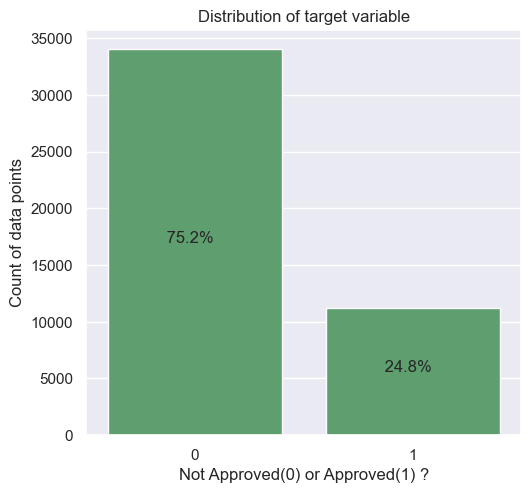

In [21]:
sns.set(rc={'figure.figsize':(5,5)})
ax = sns.countplot(credit_data,x='approved', color="g")
total = len(credit_data['approved'])*1
plt.title("Distribution of target variable")
plt.xlabel("Not Approved(0) or Approved(1) ?")
plt.ylabel("Count of data points")
for p in ax.patches:
        ax.annotate('{: .1f}%'.format(100*p.get_height()/total), (p.get_x()+0.25, p.get_height()/2))


<b>We observe that around 25% of the application gets approved and it is clear from above graph that it is not suffering from any kind of imbalance data

# Distribution Of Target Per Gender

[20988.0, 13026.0, 9539.0, 1669.0, 0, 0]


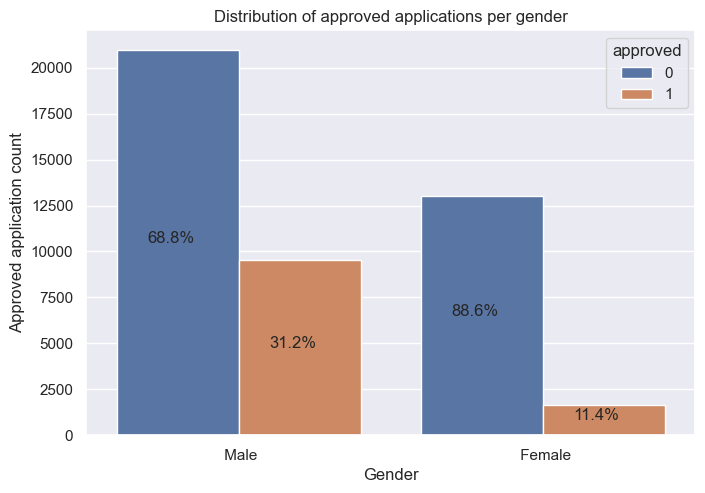

In [22]:
sns.set(rc={'figure.figsize':(7,5)})
credit_data['gender'] = pd.Categorical(credit_data['gender'],
                                   categories=[' Male',' Female'],
                                   ordered=True)
ax = sns.countplot(credit_data, x='gender',hue=credit_data['approved'])
Number_of_categories=credit_data['gender'].nunique()
hue_categories=credit_data['approved'].nunique()
a = [p.get_height() for p in ax.patches]
print(a)
patch = [p for p in ax.patches]
for i in range(Number_of_categories):
    total = credit_data['gender'].value_counts().values[i]

    for j in range(hue_categories):
        percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
        x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2-0.1
        y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height()/2
        ax.annotate(percentage, (x, y), size = 12)
plt.title("Distribution of approved applications per gender")
plt.xlabel("Gender")
plt.ylabel("Approved application count")
plt.show()

We observe that percentage of approved application among males are significantly higher than females. Even though it can be a good predictior for model, <b> We should not use it as a feature other wise it will be a gender biased model </b>

# Extracting Age From Date Of Birth Column

In [23]:
credit_data['date_of_birth'] = pd.to_datetime(credit_data['date_of_birth'])
today_date  = pd.to_datetime(datetime.today().strftime("%Y-%m-%d"))


In [24]:
credit_data['age_of_applicant']=credit_data['date_of_birth'].apply(lambda x : int((today_date-x).days/365))

# Capping Outliers

In [25]:
def iqr_cap_outliers(series, iqr_threshold=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR

    outliers = (series < lbound) | (series > ubound)

    series = series.copy()
    series.loc[series < lbound] = series.loc[~outliers].min()
    series.loc[series > ubound] = series.loc[~outliers].max()

    return series

In [26]:
display(credit_data['age_of_applicant'].describe())
credit_data['age_of_applicant']=iqr_cap_outliers(credit_data['age_of_applicant'])
display(credit_data['age_of_applicant'].describe())


count    45222.000000
mean        42.547941
std         13.217870
min         21.000000
25%         32.000000
50%         41.000000
75%         51.000000
max         94.000000
Name: age_of_applicant, dtype: float64

count    45222.000000
mean        42.511698
std         13.103689
min         21.000000
25%         32.000000
50%         41.000000
75%         51.000000
max         79.000000
Name: age_of_applicant, dtype: float64

## Relation Between Age And Approval Of Application

In [27]:
credit_data['age_bins']=pd.cut(credit_data['age_of_applicant'],[10,25,30,35,40,45,50,55,60,100])

In [28]:
approval_percentage_per_age_bin=credit_data.groupby(['age_bins'])['approved'].mean().reset_index()

2024-09-08 11:18:06,639 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-08 11:18:06,671 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


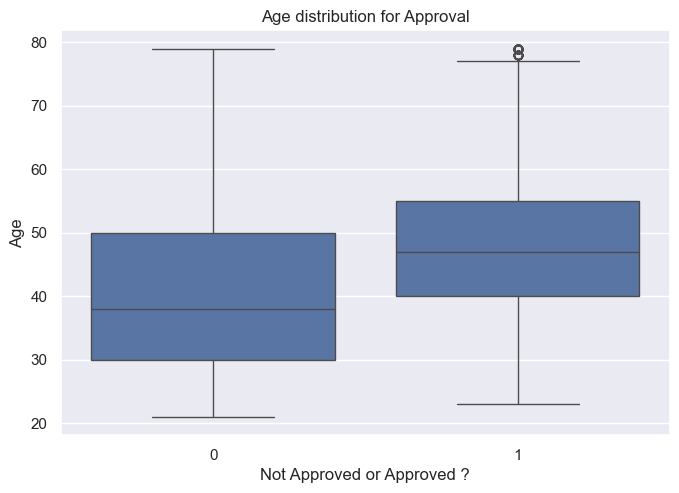

In [29]:
ax=sns.boxplot(data=credit_data, y="age_of_applicant",x="approved")
plt.title("Age distribution for Approval")
plt.ylabel("Age")
plt.xlabel("Not Approved or Approved ?")
plt.show()

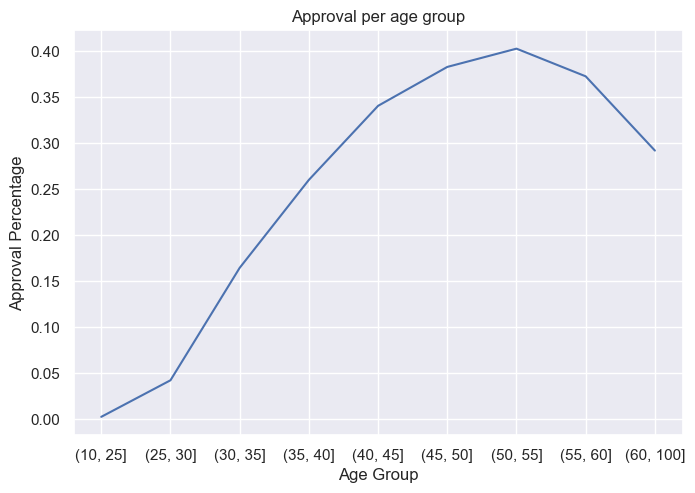

In [30]:
approval_percentage_per_age_bin['age_bins']=approval_percentage_per_age_bin['age_bins'].astype(str)
approval_percentage_per_age_bin['approved'] = approval_percentage_per_age_bin['approved'].astype(float)
sns.lineplot(approval_percentage_per_age_bin,x="age_bins", y='approved', err_style="bars")
plt.title("Approval per age group")
plt.ylabel("Approval Percentage")
plt.xlabel("Age Group")
plt.show()


<b>We observe that as age group increases there is a increase in overall approval of applications but after the age of 55 it starts reducing it may be because of retirement age and earning capacity getting reduced

# Approval Rate For Different Work-Class

In [31]:
def generatePlots(df, column_name, target_column, color, rotation, labels="percentage"):
    sns.set(rc={'figure.figsize': (12, 5)})
    plot_df = df.groupby(column_name)[target_column].mean().reset_index()
    ax = sns.barplot(data=plot_df, x=column_name, y=target_column, color=color)
    
    plt.title(f"{target_column.replace('_', ' ').title()} Vs {column_name.replace('_', ' ').title()}")
    plt.xlabel(column_name.replace('_', ' ').title())
    plt.ylabel(target_column.replace('_', ' ').title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation)

    # Loop over the bars to annotate
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2  # Use width to find the center of the bar
        _y = p.get_height()  # Get the height of the bar to place the text above it
        if labels == "percentage":
            value = f"{p.get_height() * 100:.2f}%"  # Convert to percentage
        else:
            value = f"{p.get_height():.2f}"  # Display raw value
        ax.annotate(value, (_x, _y), ha="center", va="bottom")  # Add the text annotation

    plt.show()

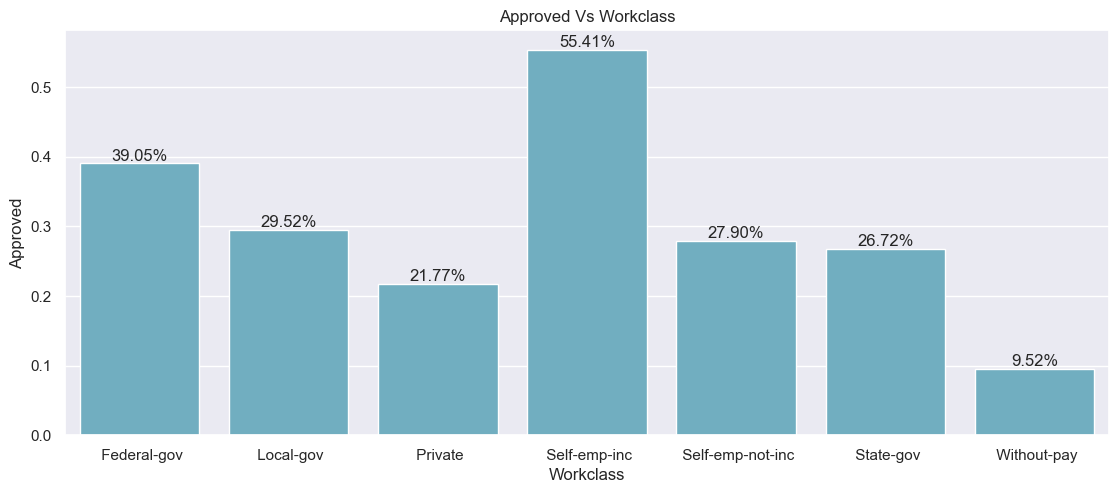

In [32]:
generatePlots(credit_data.copy(),"workclass","approved","c",0)

<b>We observe that Self Employed people have highest approval percentage and without pay people have least approval rate

<b>Without pay workcalss user id "dfc97023-6a51-4abb-ab5a-93a771ed8e83"  and "4f40d259-f836-4c02-b61a-60c040277246" are having positive capital gain is it possible or is it an anomaly ?

# Approval Rate For Different Education Level

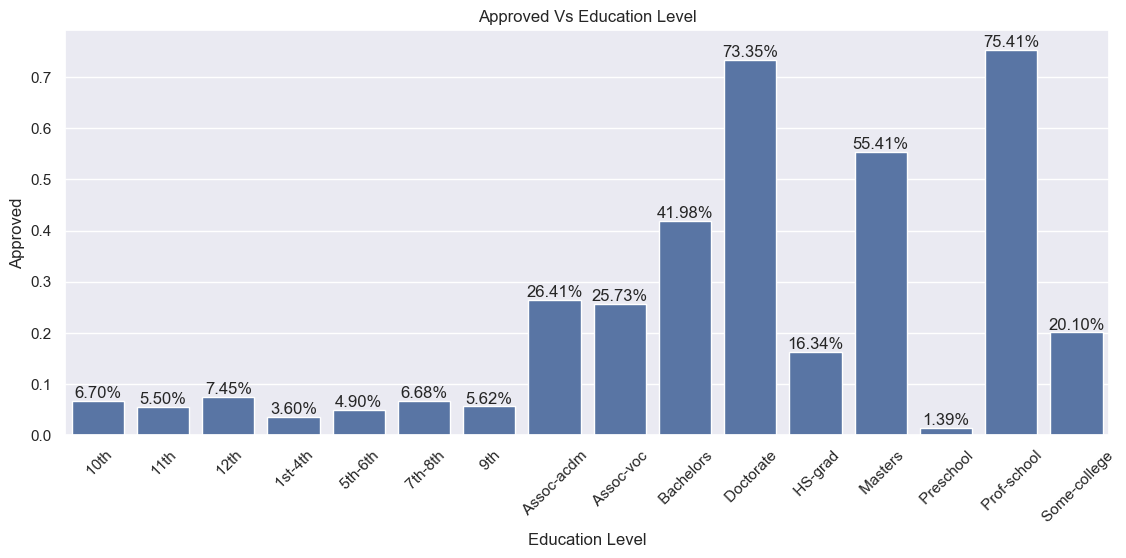

In [33]:
generatePlots(credit_data.copy(),"education_level","approved","b",45)

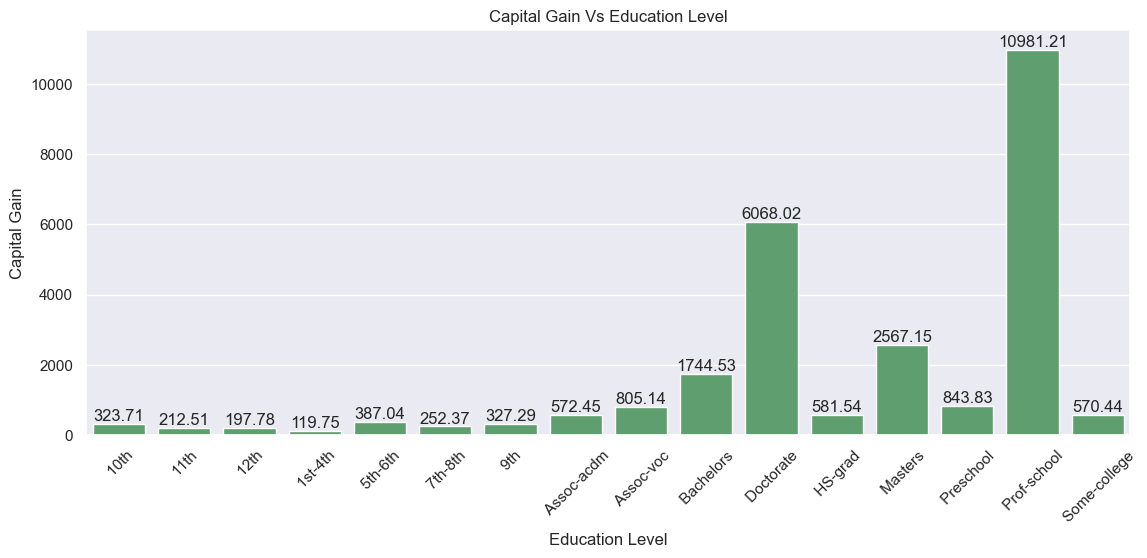

In [34]:
generatePlots(credit_data.copy(),"education_level","capital_gain","g",45,None)
# credit_data.groupby(['education_level'])['capital_gain'].mean()

<b>We observe as the person has higher degree there is a better chance of application getting approved highest among Prof-School, and this is because we have highest capital gains in almost same order i.e. highest for Prof-School & Doctorates

# Education Level & Education Number relation

In [35]:
pd.crosstab(credit_data['education_level'],credit_data['education_num'])

education_num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
education_level,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,1223,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1619,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,577,0,0,0,0,0,0,0,0
1st-4th,0,222,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,449,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,823,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,676,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1507,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1959,0,0,0,0,0


<b> Observations:<br>
    We can clearly see there is one to one mapping for education level and eucation number, thus the two columns will provide similar information to the models

# Approval Rate Per Marital Status

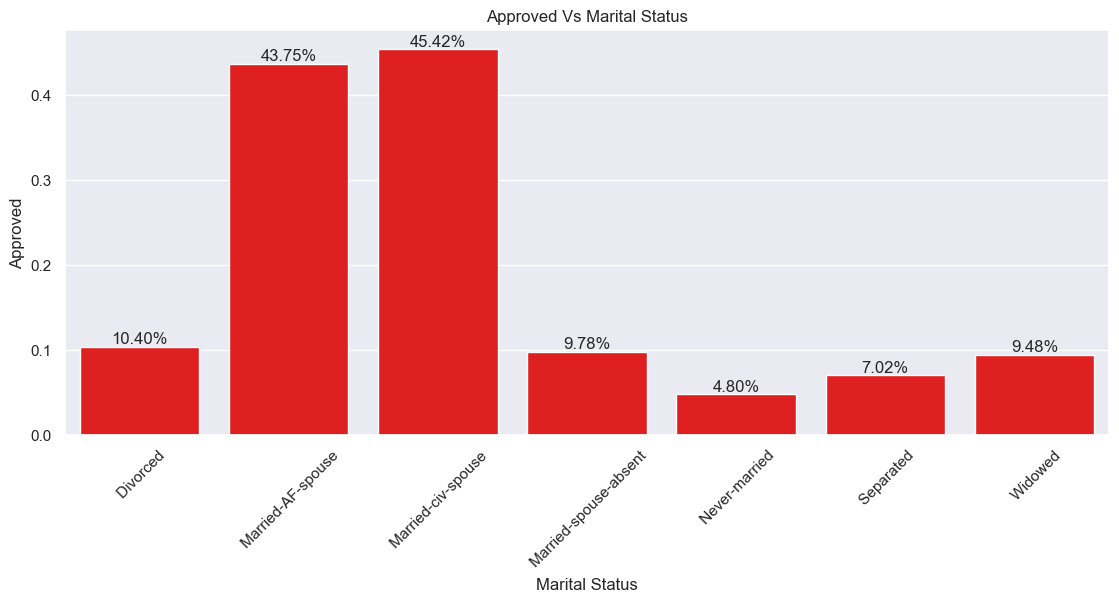

In [36]:
generatePlots(credit_data.copy(),"marital_status","approved","red",45)
# credit_data.groupby(['education_level'])['capital_gain'].mean()

<b> Married people with spouse are having very high approval rate it may be because of better financial stability

# Approval Rate For Different Occupation

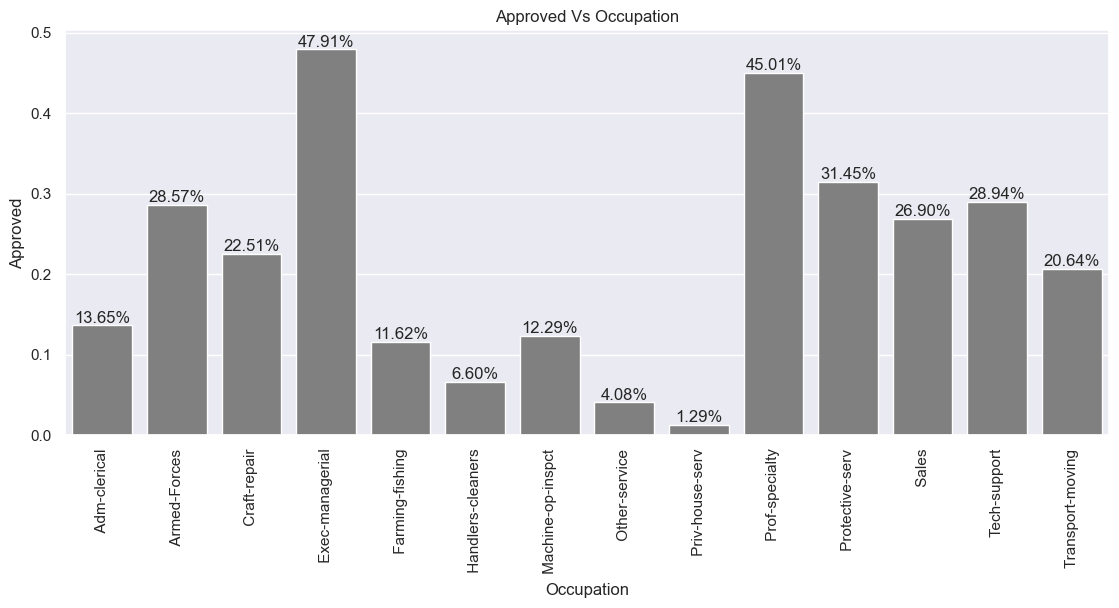

In [37]:
generatePlots(credit_data.copy(),"occupation","approved","grey",90)

<b>Professors and Managers are having a very high approval rate as compared to other occupations

# Approval Rate For Different Relationship Status

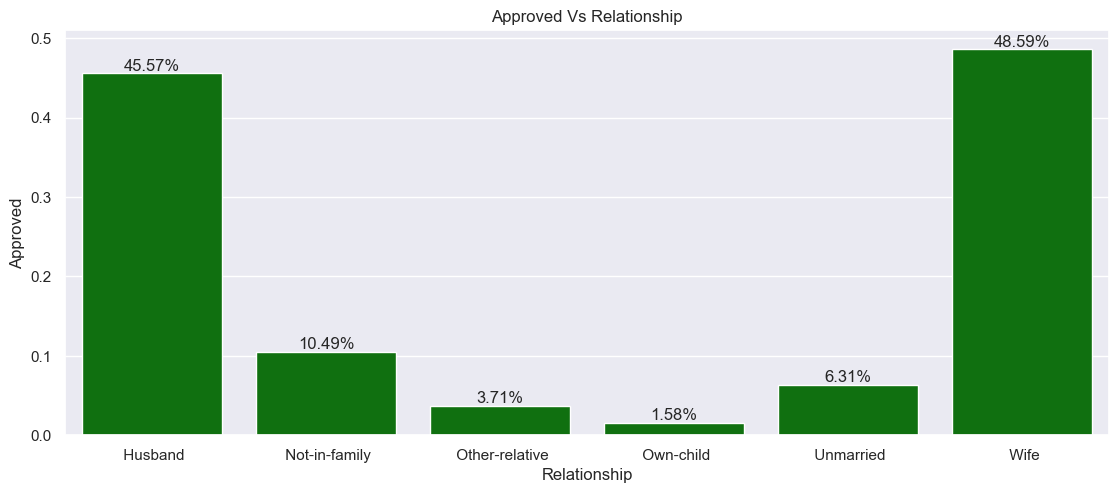

In [38]:
generatePlots(credit_data.copy(),"relationship","approved","green",0)
# credit_data.groupby(['education_level'])['capital_gain'].mean()

<b>We can observe here that as seen in EDA summaries on Marital Status, Husband and Wife is having a lot of approval rate

# Captail Gain and Capital Loss

In [39]:
credit_data['capital_gain_bins']=pd.cut(credit_data['capital_gain'],10)
capital_gain_buckets=credit_data.groupby(['capital_gain_bins'])['approved'].mean().reset_index()

In [40]:
credit_data['capital_loss_bins']=pd.cut(credit_data['capital_loss'],10)
capital_loss_buckets=credit_data.groupby(['capital_loss_bins'])['approved'].mean().reset_index()

In [41]:
#### Creating net capital by subtracting loss from gain
credit_data['capital_profit']=credit_data['capital_gain']-credit_data['capital_loss']
#### Getting if net capital is more than 0
credit_data['capital_is_zero']=(credit_data['capital_profit']==0).astype(int)

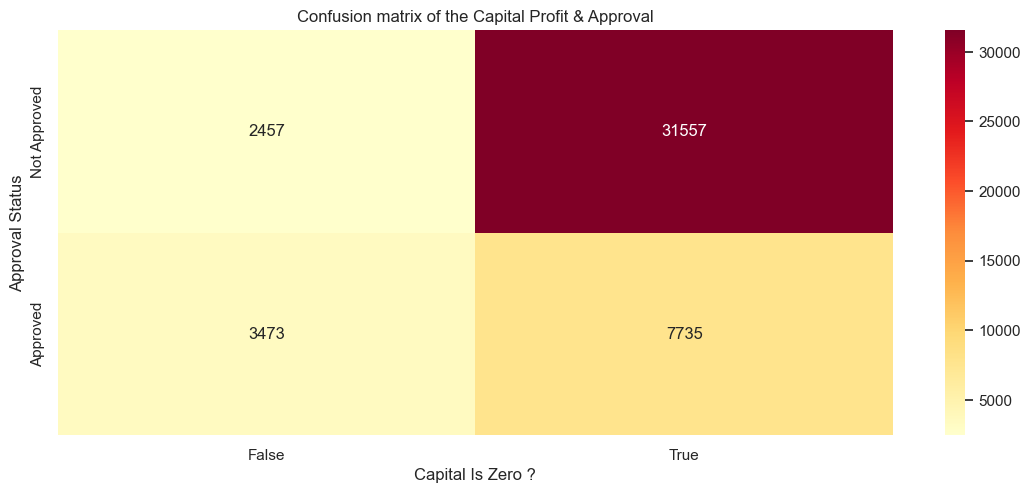

In [42]:
labels = ['Not Approved', 'Approved']
cm = confusion_matrix(credit_data['approved'],credit_data['capital_is_zero'])
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap="YlOrRd")
ax.set_ylabel('Approval Status');ax.set_xlabel('Capital Is Zero ?');
ax.set_title('Confusion matrix of the Capital Profit & Approval');
ax.yaxis.set_ticklabels(['Not Approved', 'Approved']); ax.xaxis.set_ticklabels(['False', 'True']);

<b>Observations :
1) More than 50% of the applications where capital gain is more than 0, has approval status <br>
2) The application with 0 capital gain is having more number of not approved applications

# Hours Per Week Vs Approved

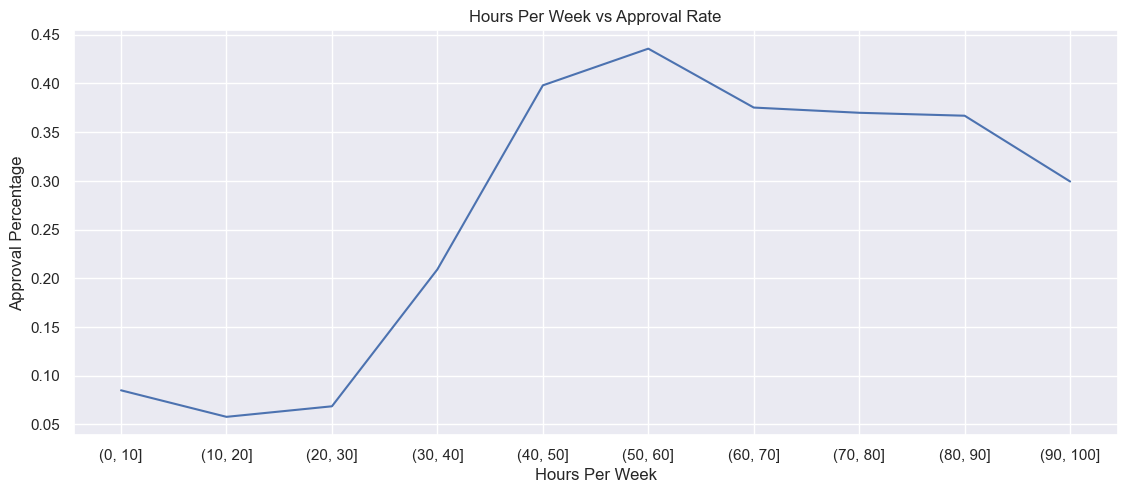

In [43]:
credit_data['hours_per_week_bins']=pd.cut(credit_data['hours_per_week'],[0,10,20,30,40,50,60,70,80,90,100])
hours_per_week_buckets=credit_data.groupby(['hours_per_week_bins'])['approved'].mean().reset_index()
hours_per_week_buckets["hours_per_week_bins"] = hours_per_week_buckets['hours_per_week_bins'].astype(str)
hours_per_week_buckets['approved'] = hours_per_week_buckets['approved'].astype(float)

sns.lineplot(hours_per_week_buckets,x="hours_per_week_bins", y="approved", err_style="bars")

plt.title("Hours Per Week vs Approval Rate")
plt.ylabel("Approval Percentage")
plt.xlabel("Hours Per Week")
plt.show()

In [44]:
display(credit_data.groupby(['hours_per_week_bins'])["occupation"].agg(lambda x:x.value_counts().index[0]).reset_index())

,hours_per_week_bins,occupation
0,"(0, 10]",Other-service
1,"(10, 20]",Other-service
2,"(20, 30]",Other-service
3,"(30, 40]",Craft-repair
4,"(40, 50]",Exec-managerial
5,"(50, 60]",Exec-managerial
6,"(60, 70]",Exec-managerial
7,"(70, 80]",Prof-specialty
8,"(80, 90]",Farming-fishing
9,"(90, 100]",Farming-fishing


<b>Observation :<br>
    
    We observe that as number of work hours increases per week approval percentage also increase
    On further analysis we found the buckets where approval percentage is high we have Managerial & Prof-Speciality roles
    which are educated section and also earns more than the other classes

# Extracting Information From Address

In [45]:
credit_data['state_name']=credit_data['address'].apply(lambda x :usaddress.parse(x)[-2][0])
credit_data['zipcode']=credit_data['address'].apply(lambda x :usaddress.parse(x)[-1][0])

In [46]:
usaddress.parse(credit_data['address'].iloc[0])

[('45424', 'AddressNumber'),
 ('Norris', 'StreetName'),
 ('Common', 'StreetNamePostType'),
 ('Apt.', 'OccupancyType'),
 ('390\n', 'OccupancyIdentifier'),
 ('North', 'PlaceName'),
 ('Mike,', 'PlaceName'),
 ('AR', 'StateName'),
 ('83962', 'ZipCode')]

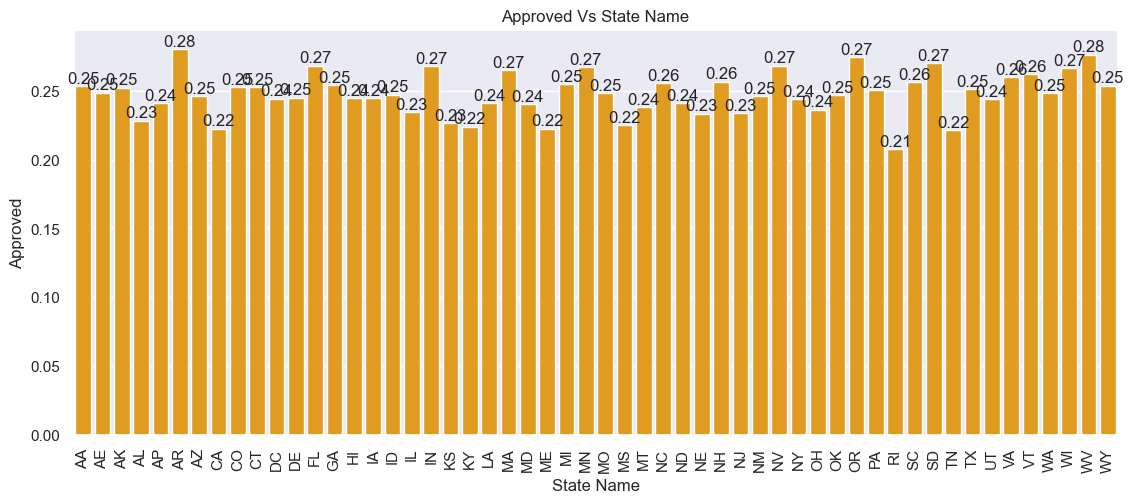

In [47]:
sns.set(rc={'figure.figsize':(80,5)})
generatePlots(credit_data.copy(),"state_name","approved","orange",90,None)

<b> Even though we are successfully able to capture the state name from the address , we observe all the states are having almost similar aproval rate

# Extracting Information from Email

In [48]:
credit_data['email_domain']=credit_data['email'].apply(lambda x: re.search("@[\w.]+", x).group().replace("@","").split(".")[-1])
credit_data['email_company']=credit_data['email'].apply(lambda x: re.search("@[\w.]+", x).group().replace("@",""))

In [49]:
### Converting less frequent one to others
credit_data['email_domain']=np.where(credit_data['email_domain'].isin(['com',
 'org',
 'biz',
 'info',
 'net',]),credit_data['email_domain'],"others")

credit_data['email_company']=np.where(credit_data['email_company'].isin(['gmail.com',
 'yahoo.com',
 'hotmail.com',]),credit_data['email_company'],"others")

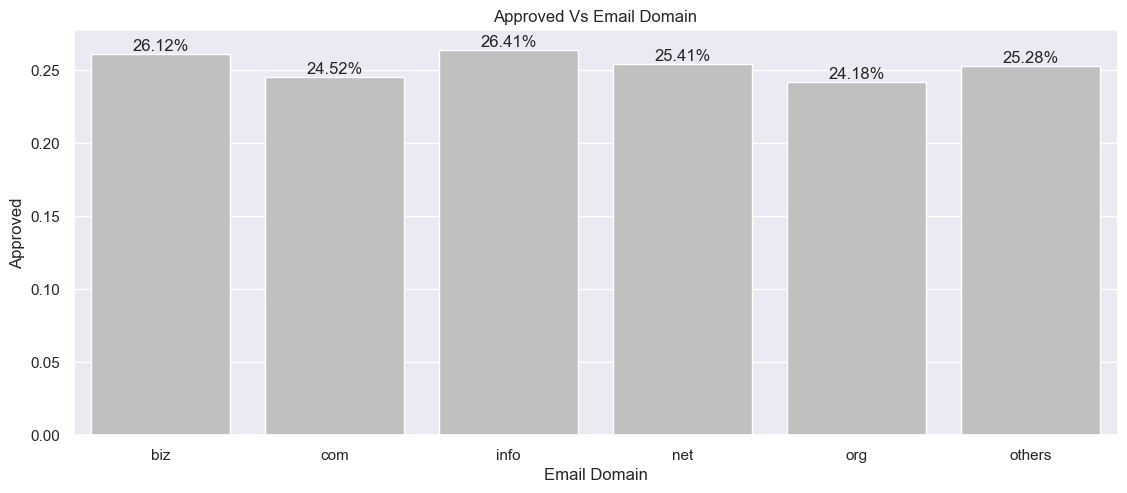

In [50]:
generatePlots(credit_data.copy(),"email_domain","approved","silver",0)

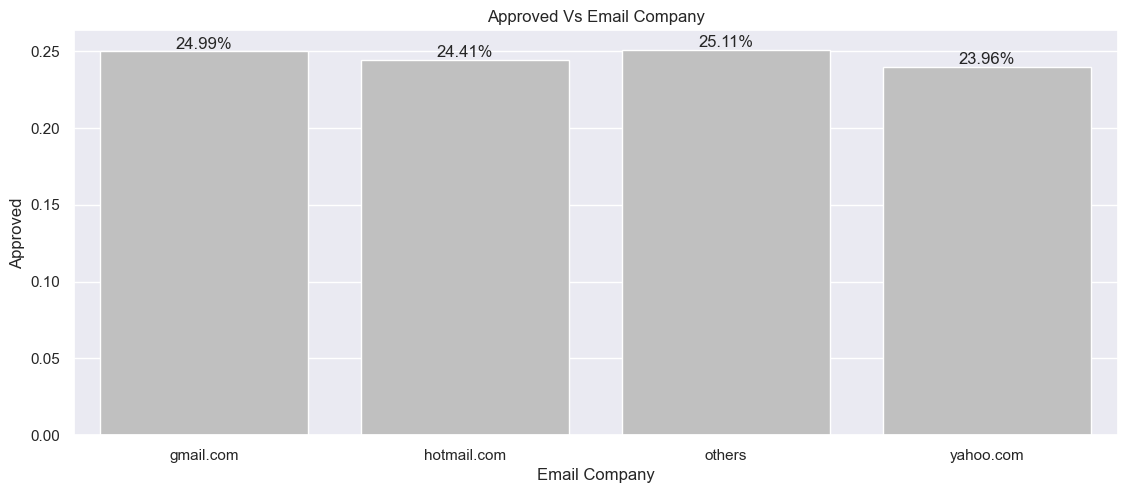

In [51]:
generatePlots(credit_data.copy(),"email_company","approved","silver",0)

<b> We observe almost all the email domains as well as compaines they are working with have almost similar approval rate

# Inquiry Purpose Code vs Approved

2024-09-08 11:19:07,770 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-08 11:19:07,775 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


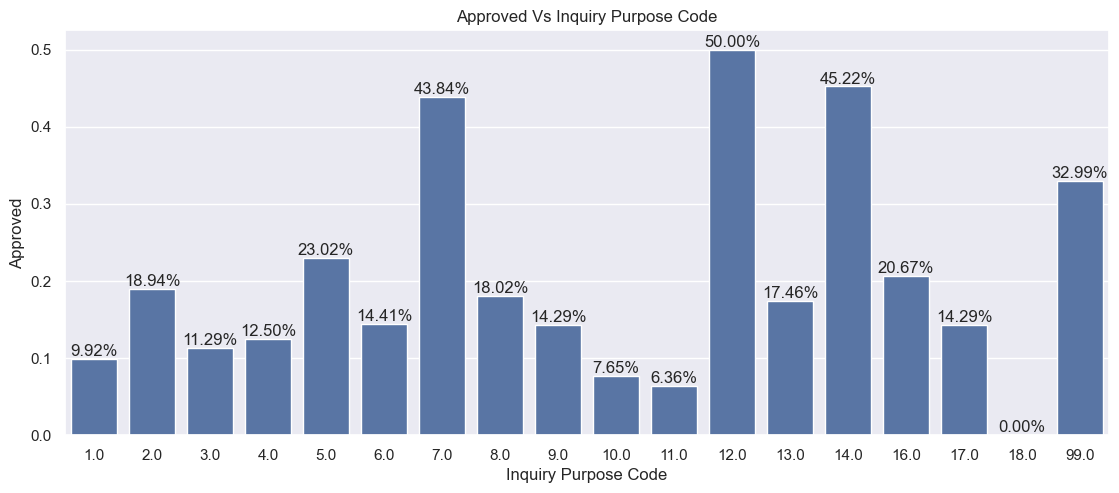

In [52]:
generatePlots(credit_data.copy(),"inquiry_purpose_code","approved","b",0)

<b>Some of the inquiries like Non-Funded Credit facility, credit card, and property loan has higher approval rate than others

# Type of Institution vs Approved

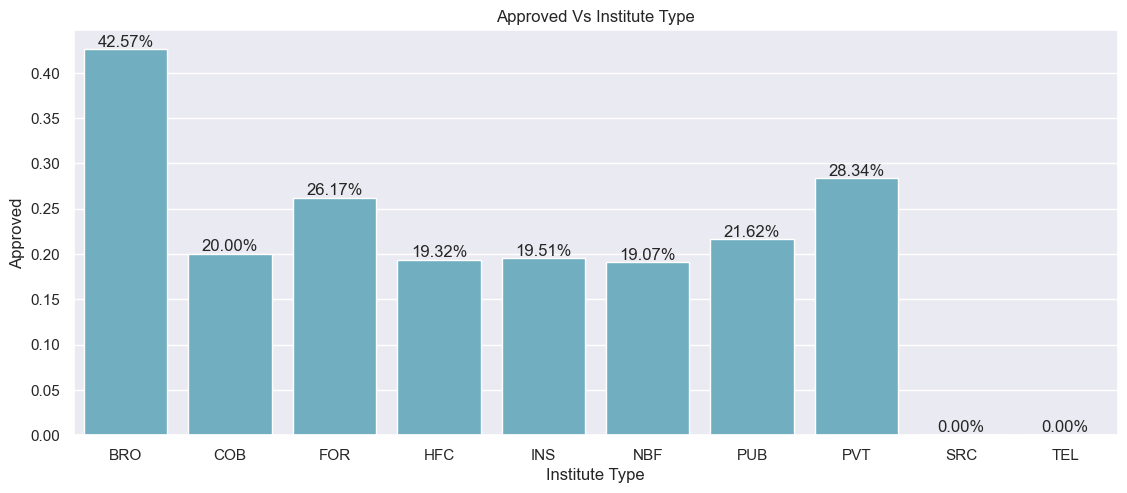

In [53]:
generatePlots(credit_data.copy(),"institute_type","approved","c",0)

<b> BRO is clearling leading in percetnage of applications geeting approved

# Asset Class vs Approved

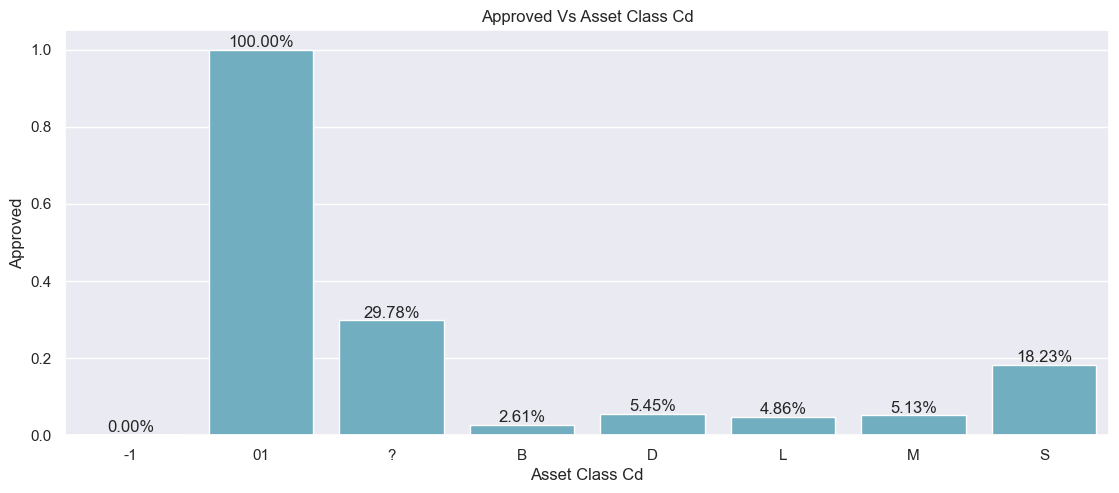

In [54]:
generatePlots(credit_data.copy(),"asset_class_cd","approved","c",0)

<b> We observe a lot of nulls here also 01 and -1 showing extreme percentage because we only have 1 record for them

## Imputation of Asset Class

In [55]:
# credit_data.groupby(["asset_code","occupation"])['asset_class_cd'].describe()
mode_function = lambda x: np.nan if x.isnull().all() else x.value_counts().index[0]
mode_df = credit_data.groupby(["asset_code",'institute_type',"occupation"])['asset_class_cd'].apply(mode_function).reset_index()


In [56]:
credit_data['asset_class_cd']=credit_data['asset_class_cd'].fillna(credit_data['asset_class_cd'].value_counts().index[0])

<b>I have tried to look the variation of asset codes using different sub-groups, but most of the iteration resulted in data frame with mostly S class

# Asset Code Vs Approved

2024-09-08 11:19:19,375 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-08 11:19:19,379 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


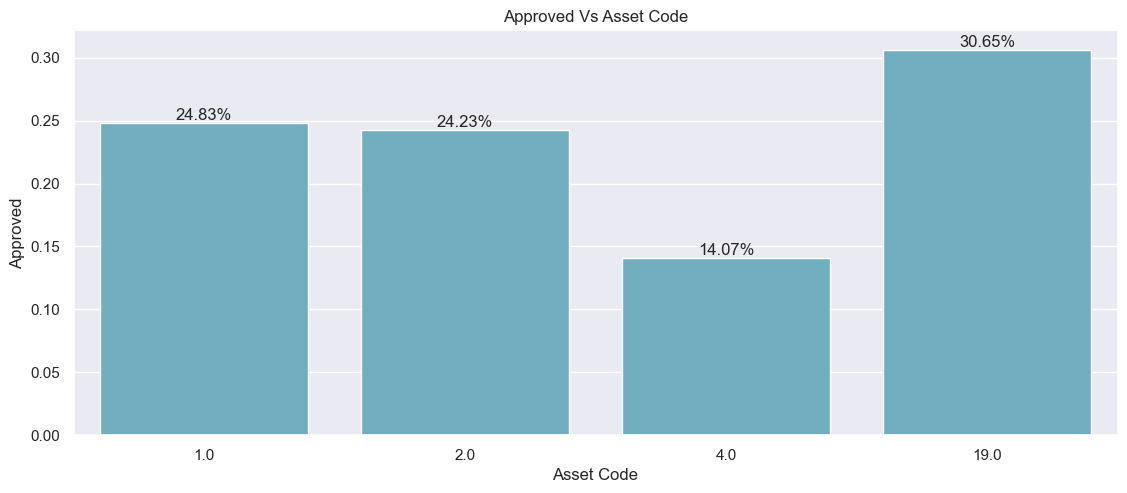

In [57]:
generatePlots(credit_data.copy(),"asset_code","approved","c",0)

<b>Authorised users have more approval rate while Guarantos have the least

# PortFolio Type vs Approved

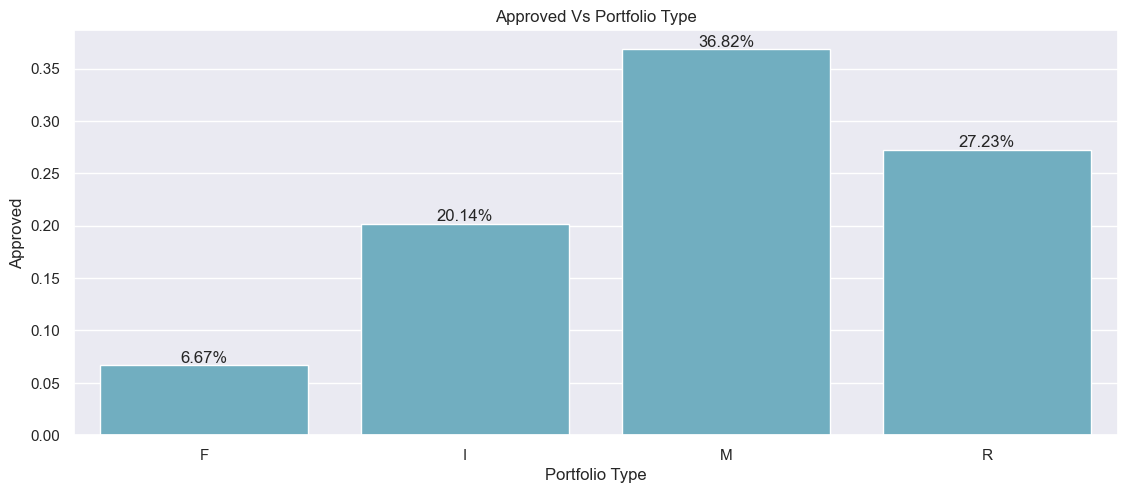

In [58]:
generatePlots(credit_data.copy(),"portfolio_type","approved","c",0)

<b>Motgage portfolio type has the highest approval percentage while microfinance has the lowest among all

# Feature Engineering (1/2)

<b>Following types of feature will be created :
1) Extracting age from the date of birth and diviving it into different bins<br>
2) Calculating net profit from capital gain and capital loss  <br>
3) Finding if capital gain and capital loss is 0 or any other positive number <br>4) Extracting Microfinance or Priority Sector information <br>
5) Defining dropout vs non-dropout <br>
6) Interaction of Domain with Occupation <br>
7) Extracting domain and company from email address <br>
8) Extracting name of the state from Address <br>
9) Label Encoding <br>
10) Target Encoding <br>
11) Direct Features <br>

In [59]:

########### Target Encoding ############################################

def meanEncoding(column_names,features,target,train,test,validation,regularisation=True):
    for i in column_names:
        item_id_target_mean = train.groupby(i)[target].mean()
        with open(f'model_artifacts/target_encoding_{i}.pkl', 'wb') as f:
            pickle.dump(item_id_target_mean, f)
        if regularisation==False:
            train[i+"_mean_encoding"] = train[i].map(item_id_target_mean)
        else:
            skf = StratifiedKFold(n_splits=3)
            train[i+"_mean_encoding"] = 0
            features=features+[i+"_mean_encoding"]
            for tr_ind, val_ind in skf.split(train[features],train[target]):
                X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
                X_val[i+"_mean_encoding"] = X_val[i].map(X_tr.groupby(i)[target].mean())

                train.iloc[val_ind]["_mean_encoding"]=X_val[i+"_mean_encoding"]
        fillnan=train[target].mean()
        test[i+"_mean_encoding"]=test[i].map(item_id_target_mean)
        validation[i+"_mean_encoding"]=validation[i].map(item_id_target_mean)

    train.reset_index(inplace=True,drop=True)
    validation.reset_index(inplace=True,drop=True)
    test.reset_index(inplace=True,drop=True)
    return train,test,validation


##################### Label Encoding #######################################

def labelEncoding(column_names,train,test,validation):
    le = LabelEncoder()
    for i in column_names:
        train[i+'_label_encoded']=le.fit_transform(train[i])
        joblib.dump(le, f'model_artifacts/label_encoder_{i}.joblib')
        test[i+"_label_encoded"]=le.transform(test[i])
        validation[i+"_label_encoded"]=le.transform(validation[i])
        train.reset_index(inplace=True,drop=True)
        validation.reset_index(inplace=True,drop=True)
        test.reset_index(inplace=True,drop=True)
    return train,test,validation

## Capital Gain is Zero & Capital Loss is Zero

In [60]:
credit_data['capital_gain_is_zero'] = np.where(credit_data['capital_gain']<=0,0,1)
credit_data['capital_loss_is_Zero'] = np.where(credit_data['capital_loss']>0,1,0)

##  Dropouts vs Non-Dropouts

In [61]:
credit_data['education_level'].unique()

array([' 11th', ' Some-college', ' HS-grad', ' Masters', ' 12th',
       ' Bachelors', ' Assoc-voc', ' Assoc-acdm', ' 9th', ' 7th-8th',
       ' 10th', ' Prof-school', ' 5th-6th', ' Doctorate', ' 1st-4th',
       ' Preschool'], dtype=object)

In [62]:
credit_data['droput_vs_non_dropout']=credit_data['education_level'].apply(lambda x: 1 if x in [' 11th',' 9th', ' 7th-8th',
       ' 10th', ' 5th-6th', ' 1st-4th',
       ' Preschool'] else 0)

# Creating Train, Validation and Test

In [63]:
train, test = train_test_split(credit_data, test_size=0.15, random_state=1,stratify=credit_data['approved'])
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

### Validation Data
train, validation = train_test_split(train, test_size=0.10, random_state=1,stratify=train['approved'])
validation.reset_index(inplace=True,drop=True)
train.reset_index(inplace=True,drop=True)

print("Shape for Train : " + str(train.shape), "Default Rate : "+str(np.round(train['approved'].mean(),2)))
print("Shape for Validation : " + str(validation.shape), "Default Rate : "+str(np.round(validation['approved'].mean(),2)))
print("Shape for Test : " + str(test.shape), "Default Rate : "+str(np.round(test['approved'].mean(),2)))



Shape for Train : (34594, 35) Default Rate : 0.25
Shape for Validation : (3844, 35) Default Rate : 0.25
Shape for Test : (6784, 35) Default Rate : 0.25


# Feature Engineering (2/2)

## Label Encoding

In [66]:
columns_for_label_encoding=["workclass","education_level","education_num","marital_status","occupation","relationship"
                           ,"email_domain","email_company","inquiry_purpose_code","institute_type","asset_class_cd","asset_code"
                            ,"portfolio_type"]

In [67]:
train,test,validation=labelEncoding(columns_for_label_encoding,train,test,validation)

## Target Encoding Binned Variables

In [68]:
columns_for_target_encoding=["hours_per_week_bins","age_bins","zipcode","state_name","account_type"]

In [69]:
train,test,validation=meanEncoding(columns_for_target_encoding,train.columns.tolist(),"approved",train,test,validation,False)

# Feature Selection

In [70]:
train.columns

Index(['user_id', 'gender', 'date_of_birth', 'workclass', 'education_level',
       'education_num', 'marital_status', 'occupation', 'relationship',
       'capital_gain', 'capital_loss', 'hours_per_week', 'approved', 'address',
       'email', 'inquiry_purpose_code', 'institute_type', 'account_type',
       'asset_class_cd', 'asset_code', 'portfolio_type', 'age_of_applicant',
       'age_bins', 'capital_gain_bins', 'capital_loss_bins', 'capital_profit',
       'capital_is_zero', 'hours_per_week_bins', 'state_name', 'zipcode',
       'email_domain', 'email_company', 'capital_gain_is_zero',
       'capital_loss_is_Zero', 'droput_vs_non_dropout',
       'workclass_label_encoded', 'education_level_label_encoded',
       'education_num_label_encoded', 'marital_status_label_encoded',
       'occupation_label_encoded', 'relationship_label_encoded',
       'email_domain_label_encoded', 'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded', 'institute_type_label_encoded',


In [71]:
## removed education level as it was correlated to education num,
## removed zip code because of too many categories
## removed capital gain and capital loss as we have dervied some features from them
universal_feature_set=['capital_gain_is_zero', 'capital_loss_is_Zero', 'droput_vs_non_dropout', 'workclass_label_encoded',
       'education_num_label_encoded',
       'marital_status_label_encoded', 'occupation_label_encoded',
       'relationship_label_encoded',
       'email_domain_label_encoded', 'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded', 'institute_type_label_encoded',
       'asset_class_cd_label_encoded', 'asset_code_label_encoded',
       'portfolio_type_label_encoded', 'hours_per_week_bins_mean_encoding',
       'age_bins_mean_encoding',
       'state_name_mean_encoding', 'account_type_mean_encoding','capital_profit','age_of_applicant']

In [72]:
len(universal_feature_set)

21

## Correlation Analysis

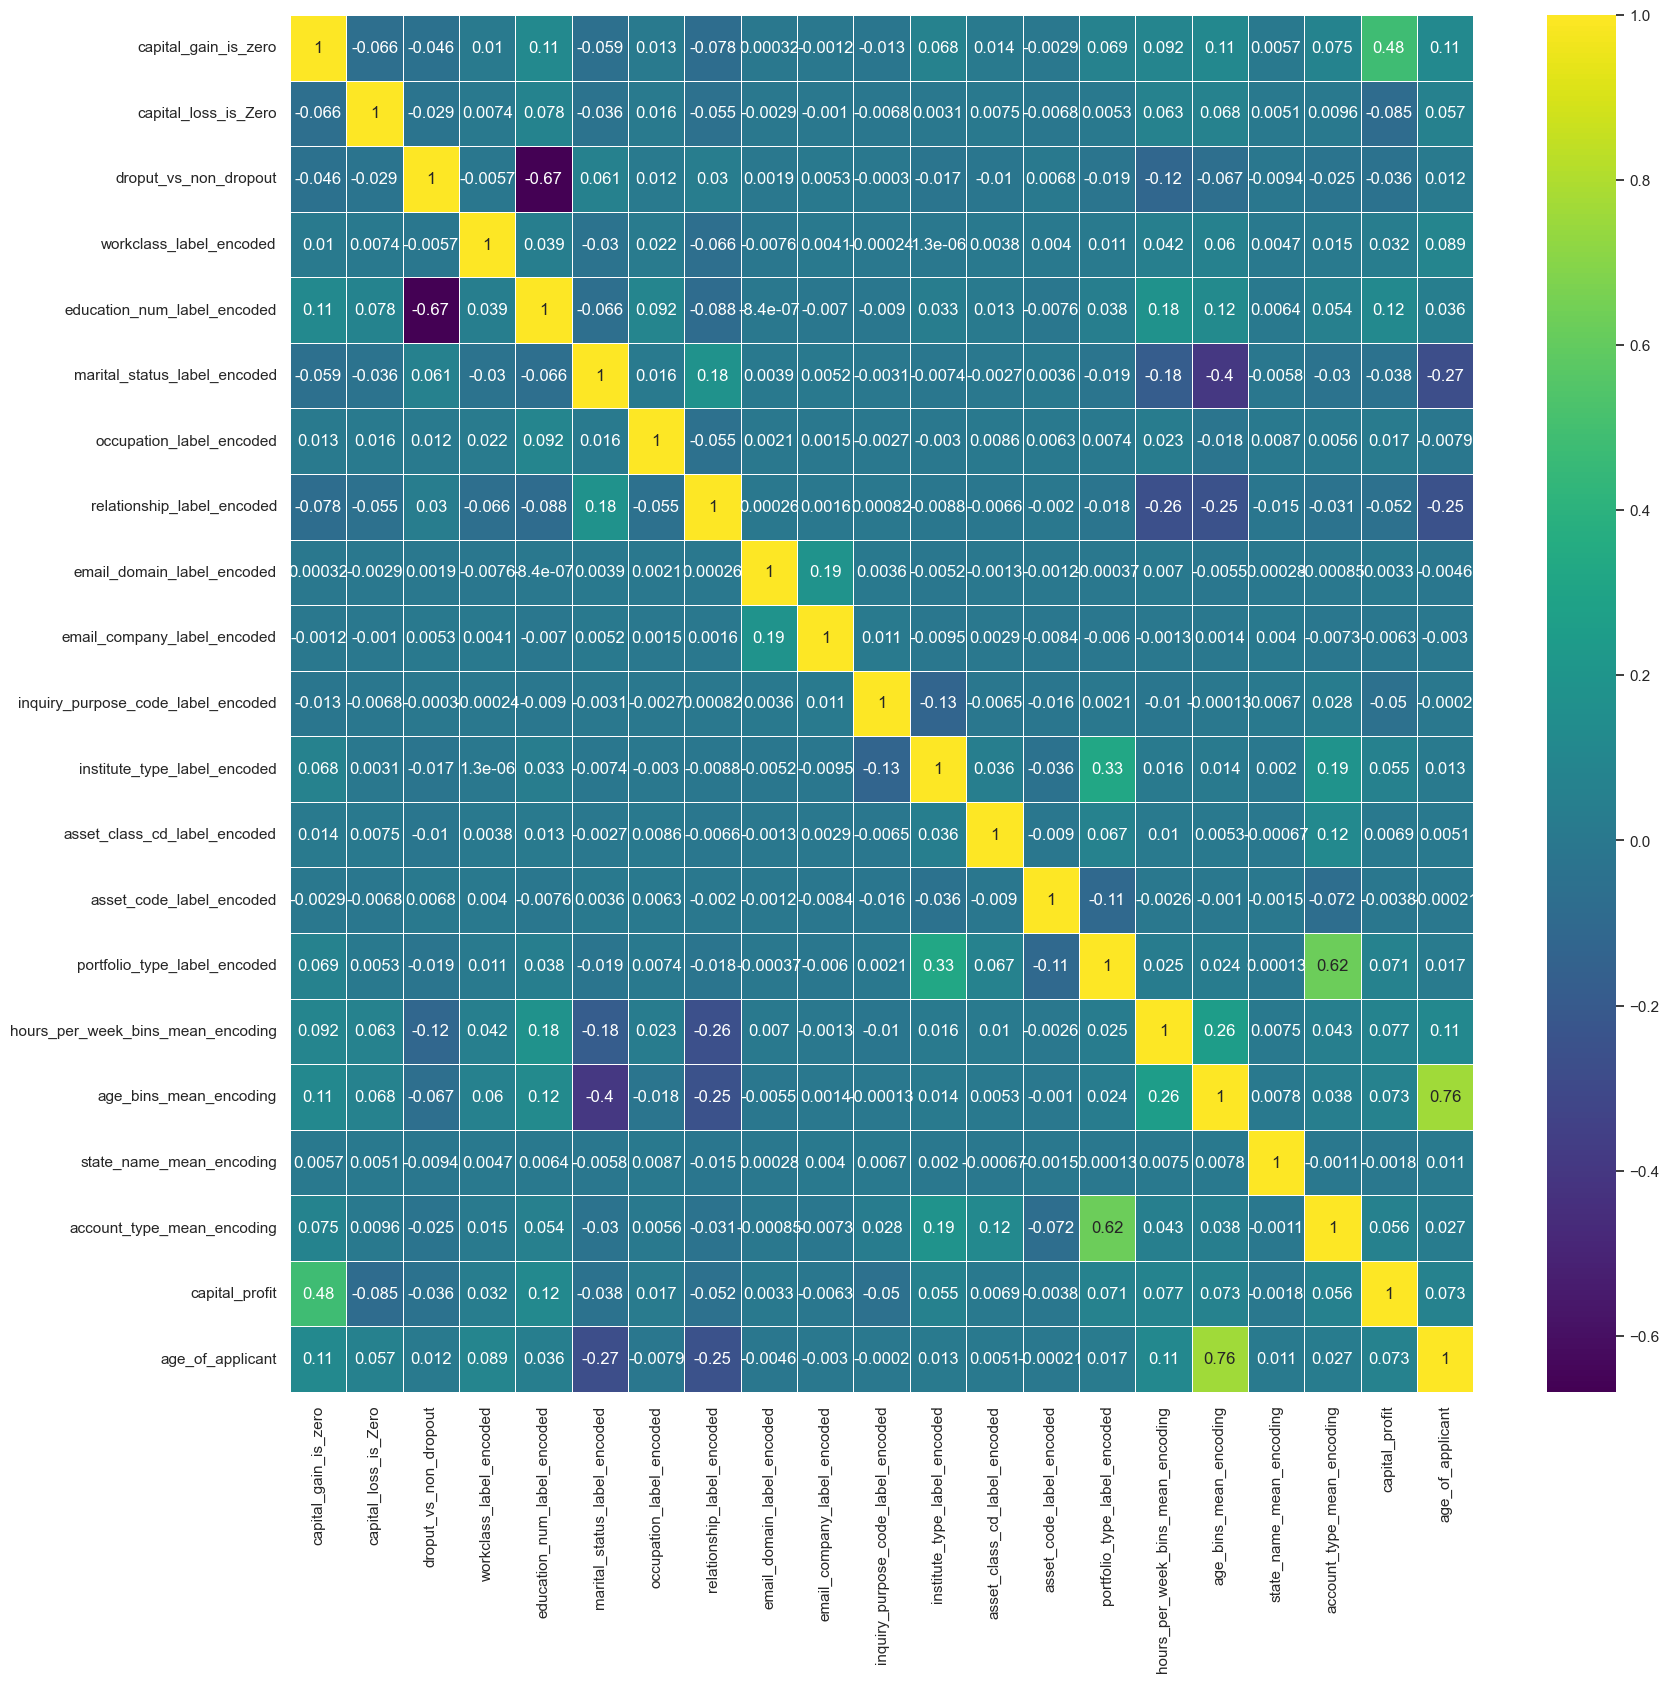

In [73]:
corremat = train[universal_feature_set].corr()
plt.figure(figsize=(17,17))
g=sns.heatmap(train[universal_feature_set].corr(),annot=True,cmap='viridis',linewidths=.5)

<b>
1) Account Type and Portfolio Type is highly correlated <br>
2) Dropout vs Non Dropout is highly related to both Education lev and Educated num

# Backward Feature Selection

In [74]:
clf = DecisionTreeClassifier(random_state=1)
recursive_eliminator = RFECV(clf,cv=StratifiedKFold(3),min_features_to_select=10,step=2,scoring="f1")
recursive_eliminator.fit(train[universal_feature_set], train['approved'])

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(random_state=1),
      min_features_to_select=10, scoring='f1', step=2)

In [75]:
columns_retained_RFECV = train[universal_feature_set].columns[recursive_eliminator.get_support()].values

In [76]:
columns_retained_RFECV

array(['capital_gain_is_zero', 'capital_loss_is_Zero',
       'workclass_label_encoded', 'education_num_label_encoded',
       'marital_status_label_encoded', 'occupation_label_encoded',
       'relationship_label_encoded', 'email_domain_label_encoded',
       'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded',
       'institute_type_label_encoded', 'asset_code_label_encoded',
       'portfolio_type_label_encoded',
       'hours_per_week_bins_mean_encoding', 'age_bins_mean_encoding',
       'state_name_mean_encoding', 'account_type_mean_encoding',
       'capital_profit', 'age_of_applicant'], dtype=object)

In [77]:
columns_retained_RFECV

array(['capital_gain_is_zero', 'capital_loss_is_Zero',
       'workclass_label_encoded', 'education_num_label_encoded',
       'marital_status_label_encoded', 'occupation_label_encoded',
       'relationship_label_encoded', 'email_domain_label_encoded',
       'email_company_label_encoded',
       'inquiry_purpose_code_label_encoded',
       'institute_type_label_encoded', 'asset_code_label_encoded',
       'portfolio_type_label_encoded',
       'hours_per_week_bins_mean_encoding', 'age_bins_mean_encoding',
       'state_name_mean_encoding', 'account_type_mean_encoding',
       'capital_profit', 'age_of_applicant'], dtype=object)

In [78]:
len(columns_retained_RFECV)

19

## Manually choosing the right set of features from auto selected features

In [79]:
universal_feature_set = ['capital_gain_is_zero', 'capital_loss_is_Zero',
       'workclass_label_encoded',
       'education_num_label_encoded', 'marital_status_label_encoded',
       'occupation_label_encoded', 'relationship_label_encoded',
       'asset_code_label_encoded',
       'capital_profit', 'age_of_applicant']

In [147]:
import json 
temp_df= credit_data[['workclass','education_num','marital_status','occupation','relationship','asset_code']]
unique_values_dict = {col: temp_df[col].unique().tolist() for col in temp_df.columns}
unique_values_json = json.dumps(unique_values_dict)
with open('model_artifacts/categorical_column_unique_values.pkl', 'wb') as f:
    pickle.dump(unique_values_dict, f)

2024-09-08 12:28:01,776 - INFO     - Executing shutdown due to inactivity...
2024-09-08 12:28:13,976 - INFO     - Executing shutdown...
2024-09-08 12:28:13,976 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [80]:
len(universal_feature_set)

10

# Modelling

In [81]:
def plotROCAUCCurve(y_train, y_train_pred, y_validation, y_validation_pred,y_test, y_test_pred):
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    validation_fpr, validation_tpr, te_thresholds = roc_curve(y_validation, y_validation_pred)

    calcAUC = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))

    plt.plot(validation_fpr, validation_tpr, label="validation AUC ="+str(auc(validation_fpr, validation_tpr)))


    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))



    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")

    plt.title("ROC Curve for Train and Validation and Test set")

    plt.grid()
    plt.show()
    return calcAUC

In [82]:
def evaluate_metrics(y_true,y_pred,model_name):

    classification_metrics={}
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    classification_metrics['model_name']=model_name
    classification_metrics["roc_auc"]=(roc_auc_score(y_true, y_pred))
    classification_metrics['au_prc'] = average_precision_score(y_true, y_pred)
    classification_metrics['brier_score']=brier_score_loss(y_true, y_pred)

    ### optimal Threshold#########
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_pred=np.where(y_pred>optimal_threshold,1,0)

    classification_metrics['recall_score']=recall_score(y_true,y_pred)
    classification_metrics['precision_score']=precision_score(y_true, y_pred)
    classification_metrics['f1_score']=f1_score(y_true, y_pred)
    classification_metrics['optimal_threshold']=optimal_threshold if optimal_threshold != np.inf else 1



    return pd.DataFrame([classification_metrics],columns=classification_metrics.keys())

## Base Model : Predicting Majority Class

In [83]:
target="approved"

In [84]:
base_model_metrics_validation=evaluate_metrics(validation[target].tolist(),[1]*len(validation),"base_model_validation")
base_model_metrics_test=evaluate_metrics(test[target].tolist(),[1]*len(test),"base_model_test")
base_model_metrics_train=evaluate_metrics(train[target].tolist(),[1]*len(train),"base_model_train")

In [85]:
base_model_results=pd.concat([base_model_metrics_train,base_model_metrics_validation,base_model_metrics_test], ignore_index=True)
base_model_results

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,base_model_train,0.5,0.247846,0.752154,0.0,0.0,0.0,1
1,base_model_validation,0.5,0.247919,0.752081,0.0,0.0,0.0,1
2,base_model_test,0.5,0.247789,0.752211,0.0,0.0,0.0,1


**ML Flow for the Base Model**

In [86]:
with mlflow.start_run():
          # Log the hyperparameters
          mlflow.log_param("optimal threshold",base_model_metrics_test['optimal_threshold'][0])
          #mlflow.log_param("n estimators",n_estimators)
          #mlflow.log_param("gamma",gamma)



          # Log the loss metric
          mlflow.log_metric("Recall Score", base_model_metrics_test['recall_score'][0])
          mlflow.log_metric("Precision Score", base_model_metrics_test['precision_score'][0])
          mlflow.log_metric("F1 Score", base_model_metrics_test['f1_score'][0])
          mlflow.log_metric("Au_Prc", base_model_metrics_test['au_prc'][0])
          mlflow.log_metric("Brier_Score", base_model_metrics_test['brier_score'][0])
          #mlflow.log_metric("recall_score", recall_score(y_true,y_pred))


          # Set a tag that we can use to remind ourselves what this run was for
          mlflow.set_tag("Predicting Majority Class", "Base Model")

          # Infer the model signature
          #signature = infer_signature(train[universal_feature_set].astype(float), xgboost_tuna.predict(train[universal_feature_set].astype(float)))

          # Log the model
          model_info = mlflow.sklearn.log_model(
          sk_model='base model test',
          artifact_path="MLRun_CreditEligibility",
          #signature=signature,
          #input_example=train[universal_feature_set].astype(float),
          registered_model_name="Checking Credit Eligibility basemodel",
                      )

2024/09/08 11:20:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/08 11:20:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Checking Credit Eligibility basemodel'.
2024/09/08 11:20:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Checking Credit Eligibility basemodel, version 1
Created version '1' of model 'Checking Credit Eligibility basemodel'.
2024/09/08 11:20:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-gnat-756 at: http://127.0.0.1:8080/#/experiments/1/runs/d52695a145d24f43901f4a0a1a74c5b1.
2024/09/08 11:20:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1.


# Try AutoML Methods 

https://pypi.org/project/TPOT/


TPOT (Tree-based Pipeline Optimization Tool) is a powerful AutoML library that automates the creation of machine learning pipelines through the use of genetic algorithms. By efficiently searching through a wide range of preprocessing steps, models, and hyperparameters, TPOT can optimize pipeline configurations to deliver high-performing models with minimal manual intervention. It seamlessly integrates with scikit-learn, supports both classification and regression tasks, and provides a user-friendly interface that generates Python code for the best pipeline. This makes TPOT a valuable tool for both experienced data scientists and those seeking to streamline their machine learning workflows.

In [87]:
from tpot import TPOTClassifier

In [89]:
tpot = TPOTClassifier(verbosity=2, generations=3, population_size=10)
tpot.fit(train[universal_feature_set].astype(float), train[target])

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8613055310111584

Generation 2 - Current best internal CV score: 0.8613055310111584

Generation 3 - Current best internal CV score: 0.8613055310111584

Best pipeline: RandomForestClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=16, min_samples_split=2, n_estimators=100)


TPOTClassifier(generations=3, population_size=10, verbosity=2)

In [91]:
tpot.export('model_artifacts/best_model_pipeline_tpot.py')

# Try Manual Models and XGboost

## XGboost with Optuna Hyper-Parameter Tuning and Universal Feature List

In [92]:
def objective(X_train, y_train, X_test, y_test, trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 4, 8)
    min_child_weight = trial.suggest_int('min_child_weight', 7, 29)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.01, 0.5, 0.01)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1,5)
    subsample = trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.6, 1.0, 0.1)
    colsample_bynode = trial.suggest_discrete_uniform('colsample_bynode', 0.6, 1.0, 0.1)
    colsample_bylevel = trial.suggest_discrete_uniform('colsample_bylevel', 0.6, 1.0, 0.1)
    reg_alpha=trial.suggest_int('reg_alpha', 1, 5)
    gamma=trial.suggest_int('gamma', 1, 5)
    reg_lambda=trial.suggest_int('reg_lambda', 1, 5)

    xgboost_tuna = xgb.XGBClassifier(n_jobs=1,
        random_state=1,
        tree_method='hist',
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        scale_pos_weight = scale_pos_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        colsample_bynode = colsample_bynode,
        colsample_bylevel = colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma



    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test_proba = xgboost_tuna.predict_proba(X_test)[:,1]
    return (1.0 - (roc_auc_score(y_test, tuna_pred_test_proba)))


In [93]:
study = optuna.create_study()
study.optimize(functools.partial(objective, train[universal_feature_set].astype(float), train[target], validation[universal_feature_set].astype(float),validation[target] ), n_trials=20)

[I 2024-09-08 11:38:53,872] A new study created in memory with name: no-name-879cd0c4-9cb6-4b01-8353-3934c442b73f
[I 2024-09-08 11:38:54,452] Trial 0 finished with value: 0.08257562366544069 and parameters: {'n_estimators': 140, 'max_depth': 4, 'min_child_weight': 28, 'learning_rate': 0.36000000000000004, 'scale_pos_weight': 3, 'subsample': 1.0, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.7, 'reg_alpha': 2, 'gamma': 3, 'reg_lambda': 5}. Best is trial 0 with value: 0.08257562366544069.
[I 2024-09-08 11:38:56,188] Trial 1 finished with value: 0.08750335284486399 and parameters: {'n_estimators': 205, 'max_depth': 4, 'min_child_weight': 28, 'learning_rate': 0.08, 'scale_pos_weight': 1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.6, 'reg_alpha': 2, 'gamma': 1, 'reg_lambda': 1}. Best is trial 0 with value: 0.08257562366544069.
[I 2024-09-08 11:38:57,743] Trial 2 finished with value: 0.07838633701653253 and parameters

In [94]:
params=study.best_params
xgb_v1 = XGBClassifier(random_state=1,**params)
xgb_v1.fit(train[universal_feature_set].astype(float),train[target])
joblib.dump(xgb_v1,"model_artifacts/xgboost_v1.joblib")

['model_artifacts/xgboost_v1.joblib']

In [95]:
xgb_universal_features_model_metrics_validation=evaluate_metrics(validation[target],xgb_v1.predict_proba(validation[universal_feature_set].astype(float))[:,1],"xgb_universal_features_validation")
xgb_universal_features_model_metrics_test=evaluate_metrics(test[target],xgb_v1.predict_proba(test[universal_feature_set].astype(float))[:,1],"xgb_universal_features_test")
xgb_universal_features_model_metrics_train=evaluate_metrics(train[target],xgb_v1.predict_proba(train[universal_feature_set].astype(float))[:,1],"xgb_universal_features_train")

xgb_universal_results=pd.concat([xgb_universal_features_model_metrics_train,xgb_universal_features_model_metrics_validation,xgb_universal_features_model_metrics_test], ignore_index=True)
xgb_universal_results

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,xgb_universal_features_train,0.948083,0.866461,0.106619,0.916025,0.631604,0.747680,0.534179
1,xgb_universal_features_validation,0.919051,0.819747,0.123830,0.895068,0.564153,0.692089,0.455570
2,xgb_universal_features_test,0.914950,0.813212,0.131349,0.861392,0.580128,0.693321,0.528018


**ML Flow for XGBoost**

In [96]:
with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_param("params",params)
      #mlflow.log_param("n estimators",n_estimators)
      #mlflow.log_param("gamma",gamma)
      # Log the loss metric
      mlflow.log_metric("Recall Score", xgb_universal_features_model_metrics_test['recall_score'][0])
      mlflow.log_metric("Precision Score", xgb_universal_features_model_metrics_test['precision_score'][0])
      mlflow.log_metric("F1 Score", xgb_universal_features_model_metrics_test['f1_score'][0])
      mlflow.log_metric("Au_Prc", xgb_universal_features_model_metrics_test['au_prc'][0])
      mlflow.log_metric("Brier_Score", xgb_universal_features_model_metrics_test['brier_score'][0])
      mlflow.log_metric("Roc_auc", xgb_universal_features_model_metrics_test['roc_auc'][0])

      #mlflow.log_metric("recall_score", recall_score(y_true,y_pred))


      # Set a tag that we can use to remind ourselves what this run was for
      mlflow.set_tag("Predicting Majority Class", "XGboost")

      # Infer the model signature
      #signature = infer_signature(train[universal_feature_set].astype(float), xgboost_tuna.predict(train[universal_feature_set].astype(float)))

      # Log the model
      model_info = mlflow.sklearn.log_model(
      sk_model=xgb_v1,
      artifact_path="MLRun_CreditEligibility",
      #signature=signature,
      #input_example=train[universal_feature_set].astype(float),
      registered_model_name="Checking Credit Eligibility XGBoost")

2024/09/08 11:39:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Checking Credit Eligibility XGBoost'.
2024/09/08 11:39:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Checking Credit Eligibility XGBoost, version 1
Created version '1' of model 'Checking Credit Eligibility XGBoost'.
2024/09/08 11:39:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-newt-725 at: http://127.0.0.1:8080/#/experiments/1/runs/7e3f32245efa49eab440f340862489fe.
2024/09/08 11:39:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1.


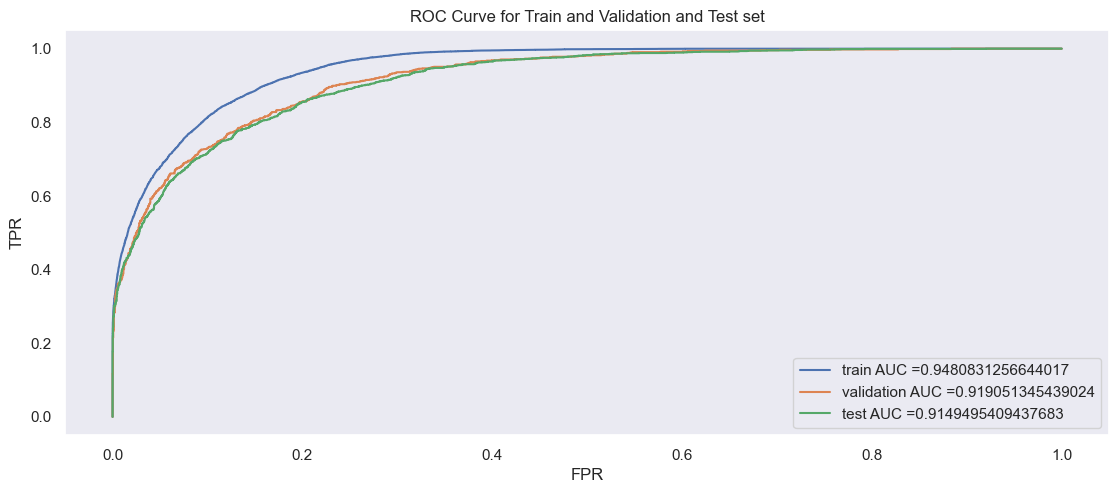

0.9149495409437683

In [97]:
plotROCAUCCurve(train[target],xgb_v1.predict_proba(train[universal_feature_set].astype(float))[:,1],validation[target],xgb_v1.predict_proba(validation[universal_feature_set].astype(float))[:,1],test[target],xgb_v1.predict_proba(test[universal_feature_set].astype(float))[:,1])

## Random Forest with Optuna Universal Features

In [98]:
def objective_rf(X_train, y_train, X_test, y_test, trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 7, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,35),
        'max_features' : trial.suggest_discrete_uniform('max_features', 0.6, 1.0, 0.1)
    }

    rf_tuna = RandomForestClassifier(random_state=1, **params)
    rf_tuna.fit(X_train, y_train)

    tuna_pred_test_proba = rf_tuna.predict_proba(X_test)[:,1]
    return (1.0 - (roc_auc_score(y_test, tuna_pred_test_proba)))

In [99]:
study = optuna.create_study()
study.optimize(functools.partial(objective_rf, train[universal_feature_set].astype(float), train[target], validation[universal_feature_set].astype(float).fillna(0),validation[target]), n_trials=15)

[I 2024-09-08 11:40:02,707] A new study created in memory with name: no-name-49d650b8-d00d-42ba-8c62-7c407f0386aa
[I 2024-09-08 11:40:05,286] Trial 0 finished with value: 0.09422973130419221 and parameters: {'n_estimators': 85, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': 0.8}. Best is trial 0 with value: 0.09422973130419221.
[I 2024-09-08 11:40:09,831] Trial 1 finished with value: 0.09603219166621602 and parameters: {'n_estimators': 198, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 23, 'max_features': 0.7}. Best is trial 0 with value: 0.09422973130419221.
[I 2024-09-08 11:40:13,840] Trial 2 finished with value: 0.10191123953449621 and parameters: {'n_estimators': 198, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 0.7}. Best is trial 0 with value: 0.09422973130419221.
[I 2024-09-08 11:40:18,617] Trial 3 finished with value: 0.08834578347318789 and parameters: {'n_estimators': 161, 'max_depth': 9, 'mi

In [100]:
params=study.best_params
params['class_weight']={0:1,1:1}
rf_v1 = RandomForestClassifier(random_state=1,**params)
rf_v1.fit(train[universal_feature_set].astype(float),train[target])
joblib.dump(rf_v1,"model_artifacts/random_forest_v1.joblib")

['model_artifacts/random_forest_v1.joblib']

In [101]:
rf_universal_features_model_metrics_validation=evaluate_metrics(validation[target],rf_v1.predict_proba(validation[universal_feature_set].astype(float).fillna(0))[:,1],"rf_universal_features_validation")
rf_universal_features_model_metrics_test=evaluate_metrics(test[target],rf_v1.predict_proba(test[universal_feature_set].astype(float).fillna(0))[:,1],"rf_universal_features_test")
rf_universal_features_model_metrics_train=evaluate_metrics(train[target],rf_v1.predict_proba(train[universal_feature_set].astype(float).fillna(0))[:,1],"rf_universal_features_train")
rf_universal_results=pd.concat([rf_universal_features_model_metrics_train,rf_universal_features_model_metrics_validation,rf_universal_features_model_metrics_test], ignore_index=True)
rf_universal_results

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,rf_universal_features_train,0.922794,0.823763,0.093208,0.868439,0.595775,0.706720,0.251351
1,rf_universal_features_validation,0.914496,0.811166,0.096824,0.818468,0.635179,0.715268,0.312919
2,rf_universal_features_test,0.908388,0.799645,0.100168,0.801904,0.618349,0.698265,0.327829


**ML Flow for Random Forest Model**

In [102]:
with mlflow.start_run():
          # Log the hyperparameters
          mlflow.log_param("params",params)
          #mlflow.log_param("n estimators",n_estimators)
          #mlflow.log_param("gamma",gamma)



          # Log the loss metric
          mlflow.log_metric("Recall Score", rf_universal_features_model_metrics_validation['recall_score'][0])
          mlflow.log_metric("Precision Score", rf_universal_features_model_metrics_validation['precision_score'][0])
          mlflow.log_metric("F1 Score", rf_universal_features_model_metrics_validation['f1_score'][0])
          mlflow.log_metric("Roc_auc", rf_universal_features_model_metrics_validation['roc_auc'][0])
          mlflow.log_metric("Au_Prc", rf_universal_features_model_metrics_validation['au_prc'][0])
          mlflow.log_metric("Brier_Score", rf_universal_features_model_metrics_validation['brier_score'][0])
          #mlflow.log_metric("recall_score", recall_score(y_true,y_pred))


          # Set a tag that we can use to remind ourselves what this run was for
          mlflow.set_tag("Predicting Majority Class", "RandomForest")

          # Infer the model signature
          #signature = infer_signature(train[universal_feature_set].astype(float), xgboost_tuna.predict(train[universal_feature_set].astype(float)))

          # Log the model
          model_info = mlflow.sklearn.log_model(
          sk_model=rf_v1,
          artifact_path="MLRun_CreditEligibility",
          #signature=signature,
          #input_example=train[universal_feature_set].astype(float),
          registered_model_name="Checking Credit Eligibility RandomForest",
                      )

2024/09/08 11:41:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Checking Credit Eligibility RandomForest'.
2024/09/08 11:41:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Checking Credit Eligibility RandomForest, version 1
Created version '1' of model 'Checking Credit Eligibility RandomForest'.
2024/09/08 11:41:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run nosy-toad-380 at: http://127.0.0.1:8080/#/experiments/1/runs/4a9bc0d45f514dd6bfdf4bd441550d40.
2024/09/08 11:41:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1.


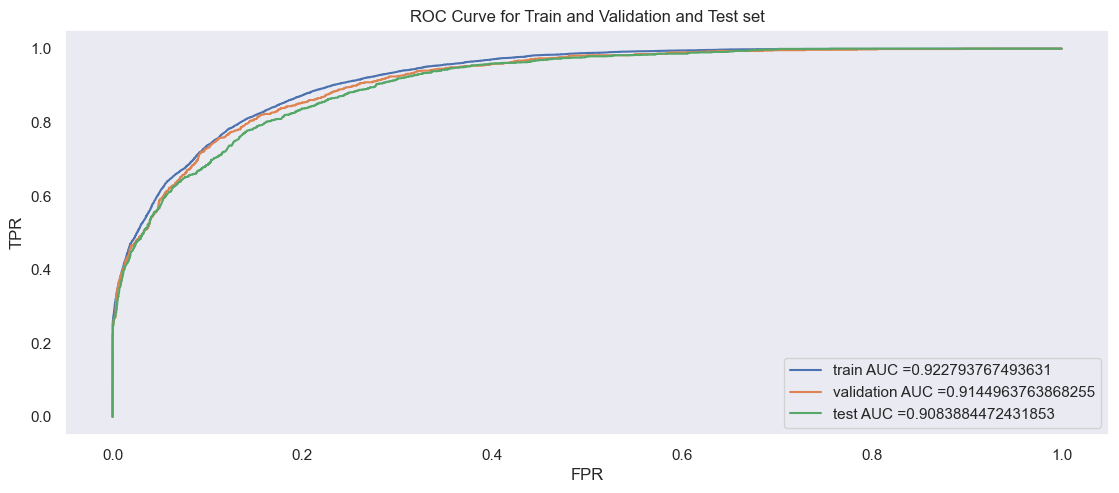

0.9083884472431853

In [103]:
plotROCAUCCurve(train[target],rf_v1.predict_proba(train[universal_feature_set].astype(float))[:,1],validation[target],rf_v1.predict_proba(validation[universal_feature_set].astype(float).fillna(0))[:,1],test[target],rf_v1.predict_proba(test[universal_feature_set].astype(float).fillna(0))[:,1])

### Feature Importance

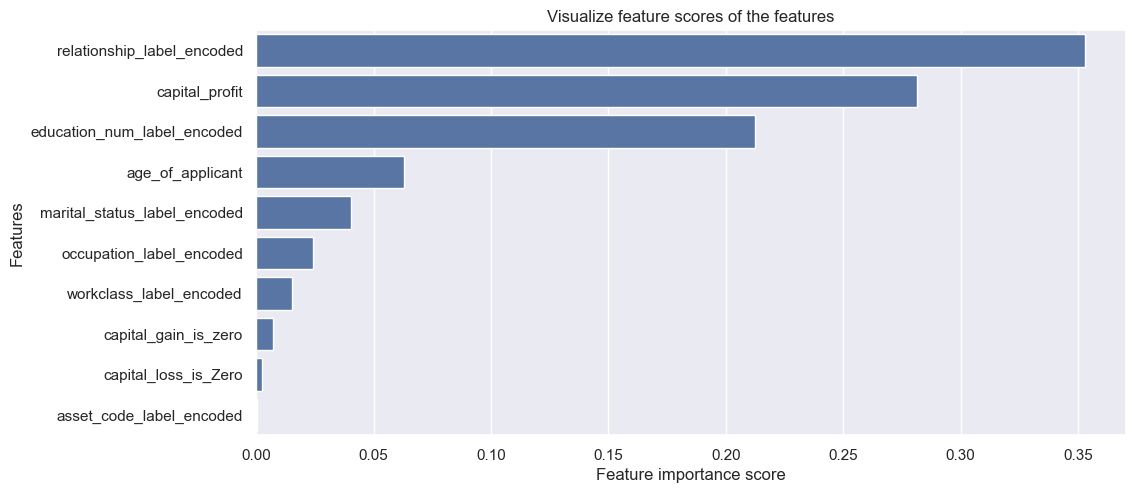

In [104]:
feature_scores = pd.Series(rf_v1.feature_importances_, index=train[universal_feature_set].columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

# Summarizing the Modelling Results

In [105]:
model_results_summary=pd.concat([base_model_results,xgb_universal_results,rf_universal_results], ignore_index=True)

In [106]:
model_results_summary

,model_name,roc_auc,au_prc,brier_score,recall_score,precision_score,f1_score,optimal_threshold
0,base_model_train,0.500000,0.247846,0.752154,0.000000,0.000000,0.000000,1.000000
1,base_model_validation,0.500000,0.247919,0.752081,0.000000,0.000000,0.000000,1.000000
2,base_model_test,0.500000,0.247789,0.752211,0.000000,0.000000,0.000000,1.000000
3,xgb_universal_features_train,0.948083,0.866461,0.106619,0.916025,0.631604,0.747680,0.534179
4,xgb_universal_features_validation,0.919051,0.819747,0.123830,0.895068,0.564153,0.692089,0.455570
5,xgb_universal_features_test,0.914950,0.813212,0.131349,0.861392,0.580128,0.693321,0.528018
6,rf_universal_features_train,0.922794,0.823763,0.093208,0.868439,0.595775,0.706720,0.251351
7,rf_universal_features_validation,0.914496,0.811166,0.096824,0.818468,0.635179,0.715268,0.312919
8,rf_universal_features_test,0.908388,0.799645,0.100168,0.801904,0.618349,0.698265,0.327829


<b> Observations : <br><br>
    1) In none of the models we have major difference between the scores of train, validation and test so we can say that
    our models are not overfitting <br>
    2) All the models are performing similar on validation and test <br>
    3) Best model based on F1-Score using test data is XGboost...

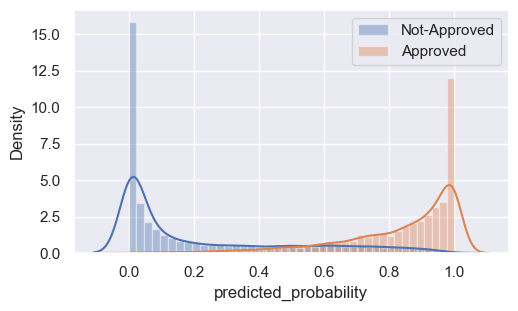

In [107]:
train_v2=train.copy()
test_v2=test.copy()
train_v2['predicted_probability']=xgb_v1.predict_proba(train_v2[universal_feature_set].astype(float).fillna(0))[:,1]
test_v2['predicted_probability']=xgb_v1.predict_proba(test_v2[universal_feature_set].astype(float).fillna(0))[:,1]



def get_seperation_plot(df):
    sns.set(rc={'figure.figsize':(5,3)})
    f, ax = plt.subplots(1, 1)
    sns.distplot(df[df[target]==0]['predicted_probability'],label="Not-Approved")
    sns.distplot(df[df[target]==1]['predicted_probability'],label="Approved")
    ax.legend()
    plt.show()


get_seperation_plot(train_v2.copy())

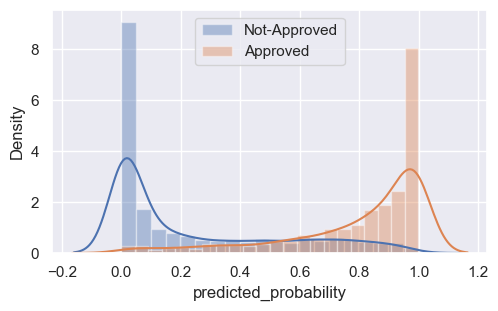

In [108]:
get_seperation_plot(test_v2.copy())

<b> We can observe that there is very clear seperation between the two classes

# Model Interpretations Using Shap

SHAP (SHapley Additive exPlanations) provides several plots to interpret machine learning models, each offering unique insights into feature contributions. 

The Summary Plot shows the distribution of SHAP values across all instances, highlighting which features have the most impact on the model’s predictions and how their effects vary. It reveals the global importance of features and their interactions with the model. 

The Dependence Plot visualizes the relationship between a single feature and the SHAP values, showing how changes in that feature influence the prediction, often revealing non-linear effects and interactions with other features. 


The Force Plot provides a detailed view of individual predictions, illustrating how each feature contributes to the final prediction relative to the base value. It helps understand specific predictions and the impact of each feature on a case-by-case basis. Collectively, these plots enable a comprehensive understanding of how features influence model outcomes, facilitating model interpretation and validation.

In [109]:
import shap

In [110]:
explainer = shap.Explainer(xgb_v1)

In [111]:
shap_values = explainer(test[universal_feature_set])

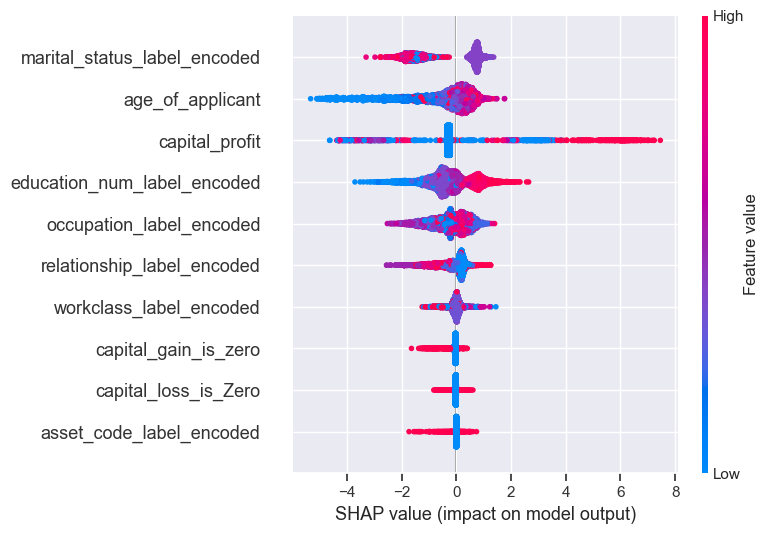

In [113]:
shap.summary_plot(shap_values, test[universal_feature_set], feature_names=universal_feature_set)

Feature Importance and Impact

marital_status_label_encoded: This feature appears to be one of the most influential factors in the model's predictions. The SHAP values are spread out, indicating that the impact of marital status on the target variable varies significantly depending on other feature values.

age_of_applicant: This feature also has a notable impact, with SHAP values concentrated around the positive range, suggesting that older applicants might have a different outcome compared to younger ones.

capital_profit: Positive SHAP values for this feature indicate that higher capital profit could be associated with a more favorable outcome. However, the distribution is relatively wide, suggesting that the impact might be influenced by other factors.

education_num_label_encoded: This feature seems to have a moderate impact, with SHAP values concentrated around the positive range, suggesting that higher education levels might be correlated with a more favorable outcome.

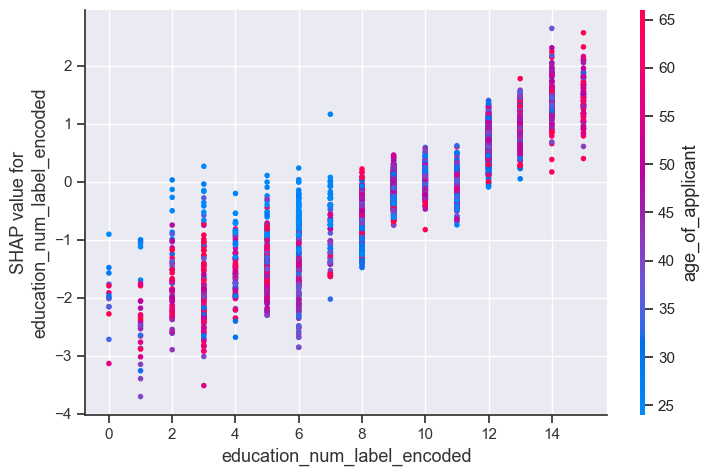

In [142]:
shap.dependence_plot("education_num_label_encoded", shap_values.values,test[universal_feature_set])

Positive Relationship: There seems to be a general positive relationship between education_num_label_encoded and the model's output. Higher education levels (larger values on the x-axis) tend to have a positive impact on the target variable (larger positive SHAP values).


Age Interaction: The color coding based on age_of_applicant reveals an interesting interaction:
For younger individuals (blue points), the positive impact of education on the target variable seems to be more pronounced.
As individuals get older (red points), the impact of education on the target variable appears to be less pronounced or even slightly negative.

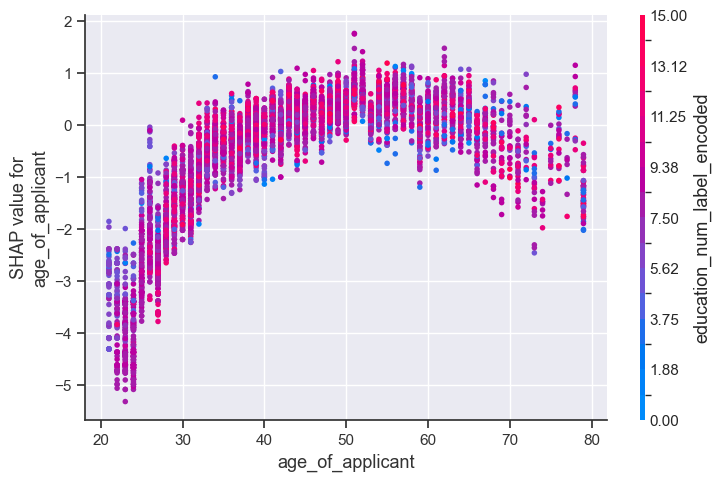

In [143]:
shap.dependence_plot("age_of_applicant", shap_values.values,test[universal_feature_set])

# Try Shap for two test data

In [137]:
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test_processed.to_numpy()[0], feature_names=universal_feature_set)

Based on this plot, we can conclude that the predicted outcome for the given instance is primarily driven by the individual's marital status. The combination of occupation and age also contributes positively to the prediction, while capital profit has a minor negative effect.

In [138]:
shap.force_plot(explainer.expected_value, shap_values[1].values, X_test_processed.to_numpy()[1], feature_names=universal_feature_set)

Based on this plot, we can conclude that the predicted outcome for the given instance is primarily driven by the individual's marital status. Education also contributes positively to the prediction, while the other features have minimal impact.